# Imports

In [34]:
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector
import os
import json
from sys import getsizeof
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.metrics import jaccard_score

from typing import List, Dict

import src.utils.utils as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'src.utils.utils' from '/Users/lams/Desktop/ADA2024/ada-2024-project-thedataminions/src/utils/utils.py'>

# Configure path to data files

In [35]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
#dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "/media/andreas/Backup_Louanne/Youniverse_dataset/" #Lou-Anne at andreas pc
#dataset_root_path = "D:/ada_project/dataset/"                                    #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon
#dataset_root_path = '/Volumes/Expansion/ada_project/dataset/' #manon at mimi disk
# dataset_root_path = "/Volumes/Backup/Youniverse_dataset/" #Lou-Anne 
#dataset_root_path = "/Volumes/Disk Horti/Youniverse_dataset/" #Horti
dataset_root_path = "/Volumes/Expansion/ada_project/dataset/" #Lams with mila's disk

# Part 1 : Data handling and filtering

## Loading the data - done in order to know how the data looks like

In [8]:
# load channel data (no chunks needed, as the file is not very large)


df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") 

In [9]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data

df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) 

# load (first 1000000 rows of) comment data

df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000)

In [10]:
def videos_in_chunks( chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", 
                        compression="infer", lines=True, chunksize=chunksize,)
                        #nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", 
                       compression="infer", sep="\t", chunksize=chunksize, )
                       #nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                          # (remove the paranthesis above as well)

## Filtering for NaNs,empty values and possible spaces

## 1. Analyzing if filtering is needed

In [20]:
#to create the filepath for the different get entries below , need to have "../generated_data" which exists:

# Define the path to the directory
output_dir = os.path.join(dataset_root_path, "../generated_data")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

First we get all values that are NaN, empty and spaces in order to decide how we will treat the data, and if cleaning the data is needed. 

### a. Youtube Comments 

In [ ]:
# get the entries of the comment dataframe which have a NaN value, empty string or space in any column

nans_empty_space_comments_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_comment_dataset.csv"  # path to file with nans in comment dataset

try:  # try to read the data from file
    df_nans_empty_space_in_comments = pd.read_csv(nans_empty_space_comments_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_comments = dp.run_simple_function_on_chunks_concat(comments_in_chunks(1000000), 
                                                                              lambda x: dp.get_na_empty_space_entries(x, "any", reverse=False),
                                                                              print_time=(1000000, 8600000000))
    
    df_nans_empty_space_in_comments.to_csv(nans_empty_space_comments_filepath, index=False)


### b. Videos (youtube metadata)

In [ ]:
# get the entries of the video dataframe which have a NaN value, empty string or space in any column

nans_empty_space_videos_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_video_dataset.csv"  # path to file with nans in video dataset

try:  # try to read the data from file
    df_nans_empty_space_in_videos = pd.read_csv(nans_empty_space_videos_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_videos = dp.run_simple_function_on_chunks_concat(videos_in_chunks(), 
                                                                            lambda x: dp.get_na_empty_space_entries(x, "any", reverse=False),
                                                                            print_time=(1000000, 8600000000))
    df_nans_empty_space_in_videos.to_csv(nans_empty_space_videos_filepath, index=False)

### c. Channels

In [ ]:
# get the entries of the channel dataframe which have a NaN value, empty string or space in any column

nans_empty_space_channels_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_channel_dataset.csv"  # path to file with nans in channel dataset

try:  # try to read the data from file
    df_nans_empty_space_in_channels = pd.read_csv(nans_empty_space_channels_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_channels = dp.get_na_empty_space_entries(df_channels, "any", reverse=False)

    df_nans_empty_space_in_channels.to_csv(nans_empty_space_channels_filepath, index=False)

In [ ]:
#display to be sure this are not empty, alarming us that some data need to be discard.

display(df_nans_empty_space_in_comments)
display(df_nans_empty_space_in_videos)
display(df_nans_empty_space_in_channels)

,author,video_id,likes,replies,char


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,char
2037,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:29:13.871524,Play all my games at http://www.retrogamer3.co...,NaN,KdoFvAgj2pA,647,NaN,"NES,Disassemble,RetroGamer3,72,pin,card,replac...",NES Disassemble by RetroGamer3,2011-10-25 00:00:00,16742.0,na
2615,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:40.351811,FREE POKECOINS HERE!\nStep by Step Guide:\n1. ...,NaN,Rigecg1Tw3Q,87,NaN,"Pokemon Go,Pokemon,go,free,pokemon go pokecoin...",FREE UNLIMITED POKECOINS :: POKEMON GO :: MORE...,2016-07-12 00:00:00,46635.0,na
7937,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:22:01.132899,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,z1IBWQusOWc,55,NaN,"piano,pianist,cover,live,musician,creative,tut...",50 Cent - In Da Club (Piano Tutorial),2019-04-24 00:00:00,5790.0,na
7977,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:22:30.010478,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,gIm1ETMO-hE,269,NaN,"piano,pianist,cover,live,musician,creative,tut...",Awolnation - Sail (Piano Tutorial),2019-04-14 00:00:00,15617.0,na
7987,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:21:37.516545,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,cLJw8DHyJBE,149,NaN,"piano,pianist,cover,live,musician,creative,tut...",Fortnite Better Give Me My Kids Back (Fgteev) ...,2019-03-13 00:00:00,18663.0,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999876,People & Blogs,UCrUkgG9ychiQ0WvbiwdlP1w,2019-11-13 20:40:53.349743,Support future streams: Buy me a Ko-fi!\nhttps...,8.0,q9hFysLAjUk,8397,351.0,,Goth GF Starfire Mukbang,2018-03-31 00:00:00,38147.0,empty
999953,Howto & Style,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:59.554309,http://twitch.tv/thekingkevin\n\nSubscribe to ...,0.0,BMG0qrEiP3Q,25,34.0,,I'm on Twitch?! [Updated],2016-02-15 00:00:00,1653.0,empty
999955,Howto & Style,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:05.734691,,NaN,P-b9O9WwPaY,1530,NaN,,Answers to Q&A - Pen Spinning Stuff,2015-05-24 00:00:00,9298.0,empty
999958,Science & Technology,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:07.629776,"So as many of you probably know, the new iPhon...",6.0,tFhgS6EX-CM,13,285.0,,Pen Spinning at 120fps (iPhone 5S),2013-10-26 00:00:00,20570.0,empty


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,char
62,Entertainment,NaN,UCBR8-60-B28hp2BmDPdntcQ,YouTube,28200000,301,110.0,2.0870,na
6941,NaN,2009-05-12,UCa_4DcdTB9QfK0LY9-7qWuQ,AbbaVEVO,995000,36,17265.0,2.8200,na
8295,NaN,2012-12-23,UCVOftvvuyipcn7102TUFsSQ,Baka Oppai,760128,27,21172.0,2.9225,na
8885,NaN,2009-06-05,UCqH2YMSzMaGN92Vc3VkhWnQ,Sony Pictures Home E...,770000,6561,22799.0,2.9595,na
10449,NaN,2009-10-15,UCnzCV_PxVZ-hsOrTy2NGxJw,EuropeVEVO,654000,19,27450.0,2.9825,na
...,...,...,...,...,...,...,...,...,...
135072,NaN,2012-02-04,UCfRjxraogo4vwPSajqZUnhg,Johnny Marsiglia & B...,10300,22,935163.0,24.2090,na
135287,NaN,2009-03-18,UCBkyyLkDRd_iql_OWY87BOA,SHARKSANDCREATURES,10500,139,937947.0,28.1220,na
135326,NaN,2016-07-24,UCfL3FVHRncVVoBnVI_EI8vw,spoiled milk,10600,33,938514.0,28.9550,na
136264,NaN,2013-01-28,UC1uzi-DavAwqFp4SWR3XKfA,THEKONDOR,10300,108,977157.0,53.1435,na


### Analysis
We created dataframes composed of the rows containing empty, space and NaN characters of the inital dataframes, for the videos channels and comments. However, for videos and channels, we only considered the 1000000 first rows for the videos and the 10000000 first rows of the comment data, due to timen limitations. This was done by changing the readers defined above, passing nrows=1000000 and nrows=10000000, respectively.  

Looking at the comments dataframe , an empty dataframe was returned. While it may seem unusual, looking at the information the comment dataset contains it makes sense that there are no columns (like, user_id...) with missing values. As it is empty , the dataframe is not broken either. Therefore no cleaning is necessary.

Looking at the df_nans_empty_space_in_channels, we see that most of the unknown values are in the categories , which is a crucial data for our analysis therefore we discard all rows with unknown values for the channels. 

Looking at the df_nans_empty_space_in_videos, we see that it is mainly the tags and likes and dislike counts which have their values missing. As we may need those data and want to get rid of all unknown values we remove all rows with unknown values for the videos. 

Overall the dataframes are large enough to allow that therefore the analysis will still be accurate.

In [ ]:
# delete the dataframes with nans, as we are done with the analysis at this point and no longer need them.

del df_nans_empty_space_in_comments
del df_nans_empty_space_in_videos
del df_nans_empty_space_in_channels


gc.collect()

1187

## 2. Cleaning of files: replacing empty character '' with NaN and remove all rows containing NaN

**df_channels** is treated separetly because the file is much smaller, it doesn't need to be treated in chuncks.


In [7]:
#clean df_channel and save 

channels_clean_filepath = dataset_root_path + "../generated_data/df_channels_clean.csv"

try:
    df_channels_clean = pd.read_csv(channels_clean_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_channels_clean = dp.clean(df_channels, save=False)
    df_channels_clean.to_csv(channels_clean_filepath, index=False)


display(len(df_channels_clean))
display(len(df_channels))

#one can understand that the new dataframe that will be using from now on will be df_channels_clean

Read data from file


136331

136470

When cleaning **chunks**, we need to use another function run_simple_function_on_chuncks_save_csv, that will iterate and clean the dataframe chunks after chunks, allowing processing of big dataset, that we can't load into memory if not in chunks. Then, the new files are save in another dataframe. Similarly, only the clean dataframe will be used afterwards.

In [8]:
# clean video dataframes

videos_clean_filepath = dataset_root_path + "../generated_data/df_videos_clean.csv"

if os.path.isfile(videos_clean_filepath):
    print("File already exists, no need to generate again. Delete or rename the file to regenerate it.")
else:
    dp.run_simple_function_on_chunks_save_csv(reader=videos_in_chunks(100000), 
                                              fct = lambda df: dp.clean(df, save=False).assign(description=df['description'].str.replace('\n', ' ', regex=False).str.replace(',', '', regex=False), tags = df['tags'].str.replace('\n', ' ', regex=False).str.replace(',', '', regex=False)) , 
                                              filename=videos_clean_filepath,
                                              index=False,
                                              every=15,
                                              overwrite=False,
                                              print_time=(100000, 72924794), video=True)
    
    


File already exists, no need to generate again. Delete or rename the file to regenerate it.


In [9]:
# define new reader, as videos_in_chunks used the uncleaned version:

def videos_in_chunks_clean(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the video dataset, with nans etc removed (cleaned).

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_csv(videos_clean_filepath,
                       compression="infer", chunksize=chunksize, )
                        #nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                          # (remove the paranthesis above as well)

#no need to redefine the comments_in_chuncks, as we did no cleaning


# Why News and Politics ?

With this analysis we want to investigate how popular the News&Politics category is both in videos and channels. 
News and Politics were chosen as it is a interesting subject to see if groups are isolated. But what is its position among all Youtube categories?

#### 1. Distribution of categories for the channels

Loaded data from file


,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22944
4,Film and Animation,6875
5,Gaming,20141
6,Howto & Style,11875
7,Music,24283
8,News & Politics,2263
9,Nonprofits & Activism,969


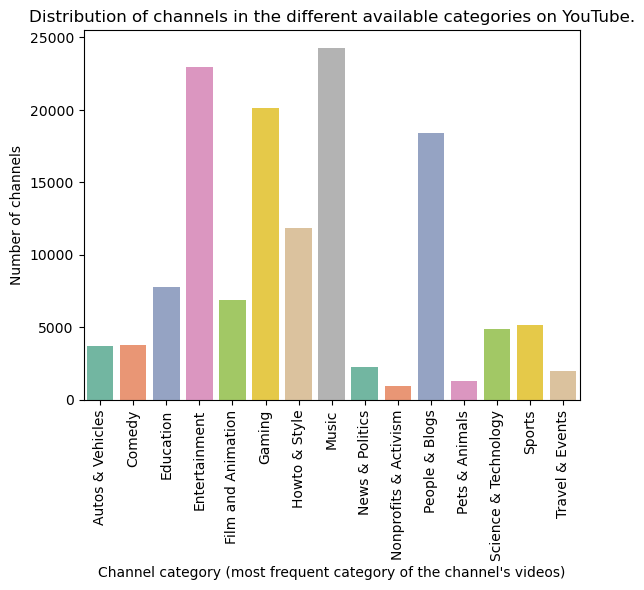

In [ ]:
channels_by_category_filepath = dataset_root_path + "../generated_data/channel_count_per_category.csv"

try:  # try to read data from file
    channels_per_category = pd.read_csv(channels_by_category_filepath)
    print("Loaded data from file")
except FileNotFoundError:  # if file does not exist, generate it and save
    channels_per_category = df_channels_clean.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
    channels_per_category.to_csv(channels_by_category_filepath, index=False)

display(channels_per_category)


ax = sns.barplot(x="category_cc", y="number_of_channels", data=channels_per_category,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of channels in the different available categories on YouTube.")
plt.xlabel("Channel category (most frequent category of the channel's videos)")
plt.ylabel("Number of channels")
plt.show()

 
One can see that the number of channels corresponding to News&Politics category is very low ! This category is even one of the smallest. What about the number of corresponding videos ?

#### 1. Distribution of categories for the channels

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
1.651 secs per chunk on average. Meaning  20.036 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
1.451 secs per chunk on average. Meaning  17.589 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
1.335 secs per chunk on average. Meaning  16.162 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
1.292 secs per chunk on average. Meaning  15.614 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
1.187 secs per chunk on average. Meaning  14.323 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
1.343 secs per chunk on average. Meaning  16.188 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
1.414 secs per chunk

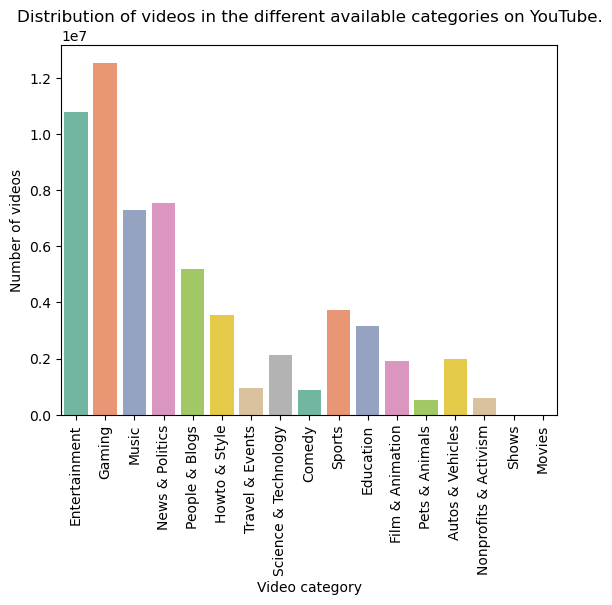

In [10]:
#distribution categories of videos over the whole (cleaned) dataset per chunck

videos_by_category_filepath = dataset_root_path + "../generated_data/video_count_by_category.csv"

try:  # try to read the data from file
    videos_per_category_counts_total = pd.read_csv(videos_by_category_filepath)
    print("Data read from file")
except FileNotFoundError:  # otherwise, generate it and save

    # Apply the function to all chunks and get the results concatenated
    videos_per_category_counts_per_chunk = dp.run_simple_function_on_chunks_concat(
        videos_in_chunks_clean(chunksize=100000), 
        dp.count_videos_by_category,
        print_time=(100000, 72924794)
        )

    # Sum the counts across all chunks to get the total count of videos per category
    videos_per_category_counts_total = videos_per_category_counts_per_chunk.sum().to_frame(name='total_count').reset_index()
    videos_per_category_counts_total.columns = ['category', 'total_count']

    videos_per_category_counts_total.to_csv(videos_by_category_filepath,)  # save the created dataframe so we don't have to generate it again


# Display the final distribution
print(videos_per_category_counts_total)

ax = sns.barplot(x="category", y="total_count", hue='category', legend=False, data=videos_per_category_counts_total, palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of videos in the different available categories on YouTube.")
plt.xlabel("Video category")
plt.ylabel("Number of videos")
plt.show()

### Analysis 

It is apparent that there are fewer News & Politics channels compared to other categories. However, the proportion of News & Politics videos is much higher. This suggests that News & Politics followers are relatively active in posting content.

Therefore, studying News & Politics videos seems to be a worthwhile pursuit, with a large enough number of videos available, even though it will naturally not fully represent the broader YouTube community. 




In [ ]:
# delete the datasets, as we don't need them anymore

del videos_per_category_counts_total
del channels_per_category

## Filtering the datasets to our needs - News & Politics

### Filtering **videos** by category 'News & Politics'

In [11]:
# filter the video dataframe to only include videos from n&p category

videos_in_news_pol_filepath = dataset_root_path + "../generated_data/videos_in_news_pol.csv"

if os.path.isfile(videos_in_news_pol_filepath):  # if the file already exists
    print("File already exists, no need to generate again.\nDelete or rename the existing file in order to regenerate it.")
else:  # if not, generate the file. The data is directly saved to a new dataframe, 
       # because it would be to big to load in memory at once
    dp.run_simple_function_on_chunks_save_csv(videos_in_chunks_clean(chunksize=100000),
                                              lambda x: x[x.categories == "News & Politics"], 
                                              filename=videos_in_news_pol_filepath,
                                              index=False,
                                              overwrite=False,  # will not overwrite existing files
                                              every=15,  # will save to the csv every 15 chunks
                                              print_time=(100000, 72924794), video=True)
    
# a new filtered file is saved, this dataframe will be used from now on.

File already exists, no need to generate again.
Delete or rename the existing file in order to regenerate it.


In [13]:
# load the (large) csv file that was just written, containing the videos in news and politics, in chunks, 
# and print the head of the first chunk and the shape of each chunk (this is just to show that it worked)

print("News and politics videos:\n")

total_length = 0
for i, chunk in enumerate(pd.read_csv(dataset_root_path + "/../generated_data/videos_in_news_pol.csv", chunksize=100000)):
    
    if i == 0:
        print(f"Head of chunk 0: ")
        print(chunk[chunk.channel_id == "UCupvZG-5ko_eiXAupbDfxWw"])

        display(chunk.head())
        print("The shapes of all chunks:")
    print(f"Shape of chunk number {i}: {chunk.shape}")
    total_length += chunk.shape[0]

print(f"In total {total_length} rows, which takes up {i+1} chunks.")
del chunk

print(f"{gc.collect()} garbages collected.")

News and politics videos:

Head of chunk 0: 
Empty DataFrame
Columns: [categories, channel_id, crawl_date, description, dislike_count, display_id, duration, like_count, tags, title, upload_date, view_count]
Index: []


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,RetroGamer3Live StreampoliticsTrump,Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
1,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,NWOEbolaUkraineMainstreamMediaPyschology,Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
2,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media: Facebook.com/thebookoflaura Tw...,89.0,eWXefhNB2po,707,625.0,michael jacksonlyricsmusic videocourtchildrenk...,my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
3,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:10.520209,👕 Order your shirts here: https://Teespring.co...,195.0,MBgzne7djFU,378,47027.0,FunnyEntertainmentFunLaughingEducationalLearni...,Elizabeth Warren Gets a Big Surprise at the Ai...,2019-10-03 00:00:00,374711.0
4,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:16.481889,👕 Order your shirts here: https://Teespring.co...,114.0,AbH3pJnFgY8,278,36384.0,FunnyEntertainmentFunLaughingEducationalLearni...,No More Twitter? 😂,2019-10-02 00:00:00,245617.0


The shapes of all chunks:
Shape of chunk number 0: (100000, 12)
Shape of chunk number 1: (100000, 12)
Shape of chunk number 2: (100000, 12)
Shape of chunk number 3: (100000, 12)
Shape of chunk number 4: (100000, 12)
Shape of chunk number 5: (100000, 12)
Shape of chunk number 6: (100000, 12)
Shape of chunk number 7: (100000, 12)
Shape of chunk number 8: (100000, 12)
Shape of chunk number 9: (100000, 12)
Shape of chunk number 10: (100000, 12)
Shape of chunk number 11: (100000, 12)
Shape of chunk number 12: (100000, 12)
Shape of chunk number 13: (100000, 12)
Shape of chunk number 14: (100000, 12)
Shape of chunk number 15: (100000, 12)
Shape of chunk number 16: (100000, 12)
Shape of chunk number 17: (100000, 12)
Shape of chunk number 18: (100000, 12)
Shape of chunk number 19: (100000, 12)
Shape of chunk number 20: (100000, 12)
Shape of chunk number 21: (100000, 12)
Shape of chunk number 22: (100000, 12)
Shape of chunk number 23: (100000, 12)
Shape of chunk number 24: (100000, 12)
Shape of 

## Extracting just the *Video IDs* of the Videos in News & Politics in as a Series
(In order to be able to use this without loading the entire Videos in News & Politics DataFrame)

In [8]:
videos_news_pol_display_ids_filepath = dataset_root_path + "../generated_data/videos_news_pol_display_ids.csv"

try:
    df_videos_news_pol_display_ids = pd.read_csv(videos_news_pol_display_ids_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_videos_news_pol_display_ids = dp.run_simple_function_on_chunks_concat(pd.read_csv(videos_in_news_pol_filepath, chunksize=100000, usecols=['display_id']),
                                                                                 fct = lambda df: df['display_id'],
                                                                                 print_time=True,
                                                                                 save=videos_news_pol_display_ids_filepath.replace('.csv', '')
                                                                                 )
    df_videos_news_pol_display_ids.to_csv(videos_news_pol_display_ids_filepath, index=False)

Read data from file


### Filtering **channels** by category News & Politics

In [29]:
#filter channels dataset to only include n&p

# Note: because the channel dataset is much smaller than the video dataset, we don't need to worry about chunks here
# Also, the results can be saved in a single file without a problem.

channels_news_pol_filepath = dataset_root_path + "../generated_data/channels_in_news_pol.csv"

try:
    df_channels_news_pol = pd.read_csv(channels_news_pol_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_channels_news_pol = df_channels_clean[df_channels_clean.category_cc == "News & Politics"]
    df_channels_news_pol.to_csv(channels_news_pol_filepath, index=False)

#this file will be used from now on

Read data from file


In [7]:
display(df_channels_news_pol.head())
display(df_channels_news_pol.shape)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.087
1,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.087
2,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.087
3,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.087
4,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.087


(2263, 8)

### Checking whether all videos in News and Politics are also uploaded by a channel in that category

In [14]:
# check if all videos we found in news&pol are also published by a channel in category n&p

videos_news_pol__channel_not_news_pol_filepath = dataset_root_path + "../generated_data/videos_in_news_pol__channel_not_in_news_pol.csv"


try:
    df_videos_news_pol__channel_not_news_pol = pd.read_csv(videos_news_pol__channel_not_news_pol_filepath)
    print("Read data from file")
except FileNotFoundError:
    # go through the large file of news and politics videos in chunks, 
    # and extract all videos which were not uploaded by a News & Politics channel

    df_videos_news_pol__channel_not_news_pol = dp.run_simple_function_on_chunks_concat(
        reader=pd.read_csv(dataset_root_path + "../generated_data/videos_in_news_pol.csv", chunksize=100000),
        fct=lambda chunk: chunk[np.logical_not(chunk.channel_id.isin(df_channels_news_pol.channel))],
        print_time=True
        )

     # save the resuls to a csv
    df_videos_news_pol__channel_not_news_pol.to_csv(videos_news_pol__channel_not_news_pol_filepath, index=False)

        
display(df_videos_news_pol__channel_not_news_pol.head())
display(df_videos_news_pol__channel_not_news_pol.shape)



Read data from file


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,News & Politics,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:42.593675,retrogamer3.com,16.0,dfa8RRkKoa4,9251,25.0,RetroGamer3Live StreampoliticsTrump,Retrogamer3 Political Stream,2018-08-23 00:00:00,478.0
1,News & Politics,UCzWLsxDD373D4tY8kN-0LGQ,2019-11-05 00:42:33.012228,What are the forces at work that have created ...,0.0,_dIIEMvH86k,309,9.0,NWOEbolaUkraineMainstreamMediaPyschology,Adam Curtis describes the Surkow Strategy of M...,2015-01-04 00:00:00,865.0
2,News & Politics,UCzVBu6oqlrAix0oq9T2rBFg,2019-11-19 20:40:22.403775,Social Media: Facebook.com/thebookoflaura Tw...,89.0,eWXefhNB2po,707,625.0,michael jacksonlyricsmusic videocourtchildrenk...,my thoughts on the michael jackson documentary.,2019-04-24 00:00:00,12780.0
3,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:01.617657,A young man is living a normal life with no ca...,16.0,ck6Yl8TNoWs,1257,452.0,JoiRidaCheathamJoiRidaCheathamAcceptedDetroitF...,Accepted - Award Winning Short Film,2013-10-13 00:00:00,27366.0
4,News & Politics,UCzTmNzBxLEHbpZNOCpUTWbA,2019-11-03 04:38:06.565138,Short Film,1.0,tjUajxZAIZ8,422,15.0,Joi.RidaCheathamjoiridacheathamdreadlocupdatej...,JoiRida Twin Visit (Introducing Jive Viper),2010-03-04 00:00:00,987.0


(541172, 12)

**We see that indeed, not all videos in the news and politics category belong to a channel in this category!** (541172 such videos, out of 7551328 in total in News & Politics, see output a few cells above)
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channel, but not all.

In the paper about the YouNiverse dataset, the authors say that the channel category is actually the "most frequent category". We believe that the video categories are the most relevant, as they are the 'true' categories of the content.

In [15]:
del df_videos_news_pol__channel_not_news_pol
print(gc.collect())

0


### Filtering the N&P videos by a list of channels

In [16]:
# define variables for the channel ids of CNN, ABC, BBC, Al Jazeera English and Fox
channel_id_cnn = "UCupvZG-5ko_eiXAupbDfxWw"  # CNN
channel_id_abc = "UCBi2mrWuNuyYy4gbM6fU18Q"  # ABC News
channel_id_bbc = "UC16niRr50-MSBwiO3YDb3RA"  # BBC News
channel_id_aje = "UCNye-wNBqNL5ZzHSJj3l8Bg"  # Al Jazeera English
channel_id_fox = "UCXIJgqnII2ZOINSWNOGFThA"  # Fox News

selected_channel_ids = [channel_id_cnn,
                        channel_id_abc,
                        channel_id_bbc,
                        channel_id_aje,
                        channel_id_fox]


In [20]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, ABC News, BBC News, Al Jazeera English and Fox News)

videos_news_pol_manual_selection_filepath = dataset_root_path + "../generated_data/videos_from_news_pol_from_selected_channels.csv"

try:
    df_videos_news_pol_manually_selected = pd.read_csv(videos_news_pol_manual_selection_filepath)
    print("Read data from file")
except FileNotFoundError:
   # go through the large file with videos in news and politics, 
   # and select those videos which are uploaded by one of our selected channels
    
    df_videos_news_pol_manually_selected = dp.run_simple_function_on_chunks_concat(
        reader=pd.read_csv(dataset_root_path + "../generated_data/videos_in_news_pol.csv", chunksize=100000), 
        fct=lambda chunk: chunk[chunk.channel_id.isin(selected_channel_ids)],
        print_time=False)
    
    # save the results to a csv
    df_videos_news_pol_manually_selected.to_csv(videos_news_pol_manual_selection_filepath, index=False)

display(df_videos_news_pol_manually_selected.head())
display(df_videos_news_pol_manually_selected.shape)


#checking if all channels are here and have videos
channel_ids = df_videos_news_pol_manually_selected.channel_id.unique()
print(channel_ids)

Read data from file


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:25:52.312339,God's not Dead' now available on DVD Watch the...,3.0,Tu8LeamtOmc,252,6.0,Fox FriendsClayton MorrisFamous FacesFaithGenr...,'Duck Dynasty' stars talk faith in entertainment,2014-12-29 00:00:00,344.0
1,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:25:55.983188,Shocking new tape reveals 15-year-old woman di...,2.0,a9RXcMkahu8,347,11.0,Bill OreillyOreilly FactorPersonal FreedomsVal...,Planned Parenthood Controversy,2014-12-29 00:00:00,1057.0
2,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:26:01.107518,Watters asks the folks of Cambridge Massachuse...,89.0,KrQu5grf5v8,277,1958.0,Oreilly FactorBill OreillyJesse WattersWatters...,Watters' World: Free stuff edition,2014-12-29 00:00:00,244169.0
3,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:26:07.440358,New Pew poll shows 44 percent say they are not...,6.0,CVzmKWI2OXQ,283,12.0,Bill OreillyCharles KrauthammerOreilly FactorP...,What happened to patriotism?,2014-12-29 00:00:00,798.0
4,News & Politics,UCXIJgqnII2ZOINSWNOGFThA,2019-11-01 09:25:50.948588,Jesse Watters ventures into the National Organ...,12.0,J9A7_Gjjzzg,294,448.0,Oreilly FactorBill OreillyJesse WattersWatters...,Watters' World: NOW edition,2014-12-29 00:00:00,43412.0


(162278, 12)

['UCXIJgqnII2ZOINSWNOGFThA' 'UCNye-wNBqNL5ZzHSJj3l8Bg'
 'UCBi2mrWuNuyYy4gbM6fU18Q' 'UCupvZG-5ko_eiXAupbDfxWw'
 'UC16niRr50-MSBwiO3YDb3RA']


### Split the selected news & pol **videos** in the five channels

In [21]:
# filter the video dataset to get only videos from each of our selected channels

channels = {
    'cnn': ('channel_id_cnn', 'cnn'),
    'abc': ('channel_id_abc', 'abc'),
    'bbc': ('channel_id_bbc', 'bbc'),
    'aje': ('channel_id_aje', 'aje'),
    'fox': ('channel_id_fox', 'fox')
}

# Load or filter data for each channel
df_videos_news_pol_cnn = dp.filter_channel_data(dataset_root_path, df_videos_news_pol_manually_selected, 'channel_id_cnn', 'CNN', 'cnn')
df_videos_news_pol_abc = dp.filter_channel_data(dataset_root_path, df_videos_news_pol_manually_selected, 'channel_id_abc', 'ABC News', 'abc')
df_videos_news_pol_bbc = dp.filter_channel_data(dataset_root_path, df_videos_news_pol_manually_selected, 'channel_id_bbc', 'BBC News', 'bbc')
df_videos_news_pol_aje = dp.filter_channel_data(dataset_root_path, df_videos_news_pol_manually_selected, 'channel_id_aje', 'Al Jazeera English', 'aje')
df_videos_news_pol_fox = dp.filter_channel_data(dataset_root_path, df_videos_news_pol_manually_selected, 'channel_id_fox', 'Fox News', 'fox')


Data for CNN read from file.
Data for ABC News read from file.
Data for BBC News read from file.
Data for Al Jazeera English read from file.
Data for Fox News read from file.


### Filtering **comments** from all n&p videos

In [22]:
# get comments on all (n&p) videos from our selected channels

comments_news_pol_videos_filepath = dataset_root_path + "../generated_data/comments_news_pol_videos.csv"

if os.path.isfile(comments_news_pol_videos_filepath):
    print("File already exists, no need to generate again.")
else:

    # get all the comments made on a video in the News&Pol category
    dp.run_simple_function_on_chunks_save_csv(
        comments_in_chunks(chunksize=1000000), 
        lambda comment_df: comment_df.loc[comment_df['video_id'].isin(df_videos_news_pol_display_ids.display_id)],
        comments_news_pol_videos_filepath,
        index=False,
        every=30,
        print_time=(1000000, 8600000000),)


File already exists, no need to generate again.


### Filtering **comments** of the main channels using n&p video ids obtained above

In [23]:
# get comments on (n&p) videos from our selected channels using the ids from filtered video dataset from the selected channels
# Check if all 5 channels are in the video dataset before filtering

comments_news_pol_selected_channels_filepath = dataset_root_path + "../generated_data/comments_news_pol_selected_channels.csv"

try:
    df_comments_news_pol_manually_selected = pd.read_csv(comments_news_pol_selected_channels_filepath) 

    print("Read data from file")
except FileNotFoundError:
    # get all the comments made on a video uploaded by one of our selected channels
    df_comments_news_pol_manually_selected = dp.run_simple_function_on_chunks_concat(
        pd.read_csv(comments_news_pol_videos_filepath, chunksize=1000000),  # only go through news and pol videos 
        lambda comment_df: comment_df.loc[comment_df['video_id'].isin(df_videos_news_pol_manually_selected.display_id)],
        print_time=(1000000, 8600000000))
    
     # merge it with the video data of the selected channels, to get the channel id directly in the comment df
    df_comments_news_pol_manually_selected = df_comments_news_pol_manually_selected.merge(
        df_videos_news_pol_manually_selected[["display_id", "channel_id"]], 
        left_on="video_id", right_on="display_id")
    # save as csv
    df_comments_news_pol_manually_selected.to_csv(comments_news_pol_selected_channels_filepath, index=False)

Read data from file


In [24]:
display(df_comments_news_pol_manually_selected)
display(df_comments_news_pol_manually_selected.shape)

#checking if all channels are here and have videos
channel_ids = df_comments_news_pol_manually_selected.channel_id.unique()
print(channel_ids)




,author,video_id,likes,replies,display_id,channel_id
0,30,HqBtIWFW-0k,2,2,HqBtIWFW-0k,UCBi2mrWuNuyYy4gbM6fU18Q
1,30,HqBtIWFW-0k,0,0,HqBtIWFW-0k,UCBi2mrWuNuyYy4gbM6fU18Q
2,269,anah_4blbyU,0,0,anah_4blbyU,UCupvZG-5ko_eiXAupbDfxWw
3,269,vtVvnL5SbDA,3,0,vtVvnL5SbDA,UCBi2mrWuNuyYy4gbM6fU18Q
4,336,IC1gAi0BmhM,0,0,IC1gAi0BmhM,UCBi2mrWuNuyYy4gbM6fU18Q
...,...,...,...,...,...,...
48822750,576551809,VUUbyaQYxU4,2,0,VUUbyaQYxU4,UCBi2mrWuNuyYy4gbM6fU18Q
48822751,576551877,x_dK7Y07LSs,1,0,x_dK7Y07LSs,UCXIJgqnII2ZOINSWNOGFThA
48822752,576551877,W6ZHY0E4_Wg,0,0,W6ZHY0E4_Wg,UC16niRr50-MSBwiO3YDb3RA
48822753,576551877,rfLBvU8sSWw,14,2,rfLBvU8sSWw,UC16niRr50-MSBwiO3YDb3RA


(48822755, 6)

['UCBi2mrWuNuyYy4gbM6fU18Q' 'UCupvZG-5ko_eiXAupbDfxWw'
 'UC16niRr50-MSBwiO3YDb3RA' 'UCXIJgqnII2ZOINSWNOGFThA'
 'UCNye-wNBqNL5ZzHSJj3l8Bg']


### Split the comments into the 5 main channels

In [7]:
# define the file paths for the files for comments from each of the channels

comments_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/comments_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc","bbc", "aje", "fox"]  
    ]

# check if all of the files already exist
if np.all([os.path.isfile(filepath) for filepath in comments_news_pol_selected_channels_filepaths]):
    df_comments_news_pol_cnn = pd.read_csv(comments_news_pol_selected_channels_filepaths[0])
    df_comments_news_pol_abc = pd.read_csv(comments_news_pol_selected_channels_filepaths[1])
    df_comments_news_pol_bbc = pd.read_csv(comments_news_pol_selected_channels_filepaths[2])
    df_comments_news_pol_aje = pd.read_csv(comments_news_pol_selected_channels_filepaths[3])
    df_comments_news_pol_fox = pd.read_csv(comments_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:
    # group the comments by channel
    df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (df_comments_news_pol_cnn,
     df_comments_news_pol_abc,
     df_comments_news_pol_bbc,
     df_comments_news_pol_aje,
     df_comments_news_pol_fox) = (df_comments_news_pol_manually_selected_grouped.get_group(channel_id ) 
                                  for channel_id in [channel_id_cnn,
                                                     channel_id_abc,
                                                     channel_id_bbc,
                                                     channel_id_aje,
                                                     channel_id_fox])
    
    # save the new dfs to csv
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[0], index=False)
    df_comments_news_pol_abc.to_csv(comments_news_pol_selected_channels_filepaths[1], index=False)
    df_comments_news_pol_bbc.to_csv(comments_news_pol_selected_channels_filepaths[2], index=False)
    df_comments_news_pol_aje.to_csv(comments_news_pol_selected_channels_filepaths[3], index=False)
    df_comments_news_pol_fox.to_csv(comments_news_pol_selected_channels_filepaths[4], index=False)

Read 5 dfs from file


In [26]:
df_comments_news_pol_cnn

,author,video_id,likes,replies,display_id,channel_id
0,269,anah_4blbyU,0,0,anah_4blbyU,UCupvZG-5ko_eiXAupbDfxWw
1,1015,b8Jmjloz9_k,0,0,b8Jmjloz9_k,UCupvZG-5ko_eiXAupbDfxWw
2,1548,-rN17xNnIyM,0,0,-rN17xNnIyM,UCupvZG-5ko_eiXAupbDfxWw
3,1548,-rN17xNnIyM,0,0,-rN17xNnIyM,UCupvZG-5ko_eiXAupbDfxWw
4,1560,OAjEDUYsbsY,0,0,OAjEDUYsbsY,UCupvZG-5ko_eiXAupbDfxWw
...,...,...,...,...,...,...
17977460,576550571,ElSlwPxo7r4,0,0,ElSlwPxo7r4,UCupvZG-5ko_eiXAupbDfxWw
17977461,576550571,iQGVM02jd9Q,82,9,iQGVM02jd9Q,UCupvZG-5ko_eiXAupbDfxWw
17977462,576550571,z71bpXhUmSo,0,0,z71bpXhUmSo,UCupvZG-5ko_eiXAupbDfxWw
17977463,576551701,tyUh_xSjvXQ,0,0,tyUh_xSjvXQ,UCupvZG-5ko_eiXAupbDfxWw


## Initial Analysis

Now that we have new dataframes of comments and videos for the 5 main channels, we explore the plots.

### Total number of subscribers, users (i.e commenters) and comments in the 5 channels

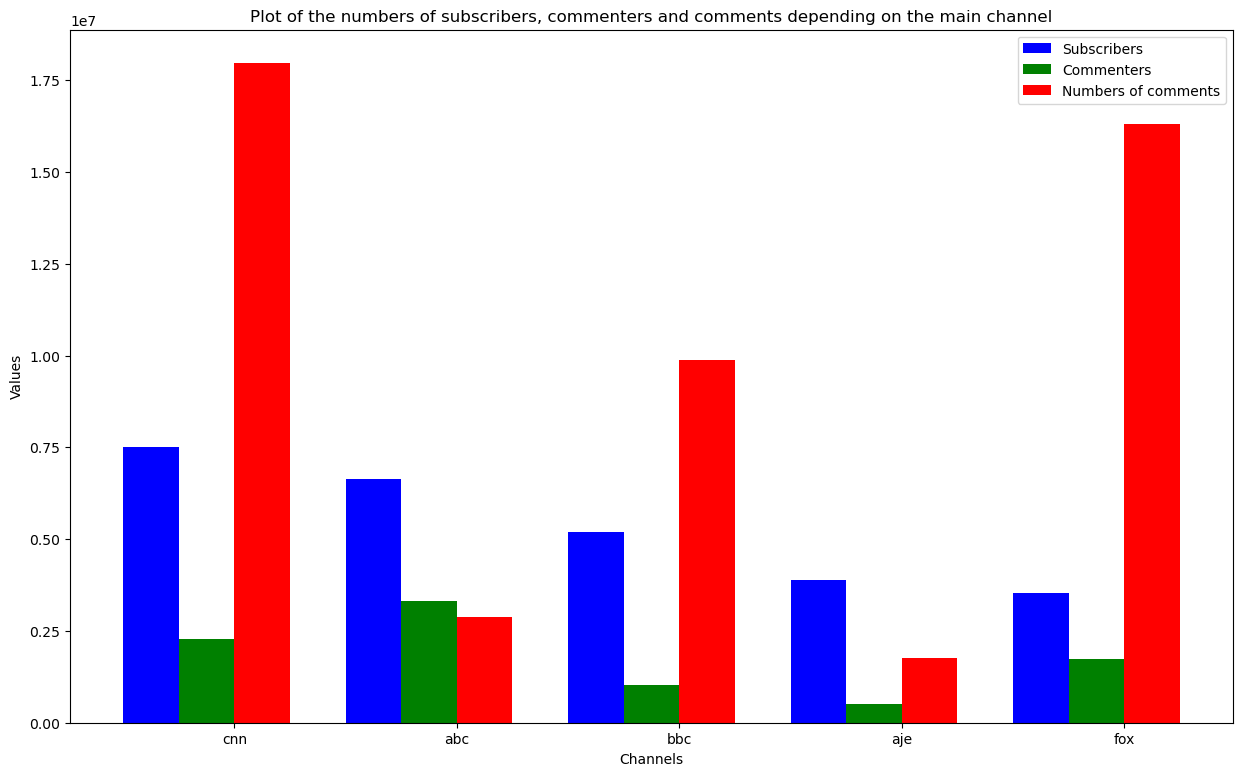

In [30]:
channels = ['cnn', 'abc', 'bbc', 
                'aje', 'fox']
#total numbers of comments
comments = [len(df_comments_news_pol_cnn), 
            len(df_comments_news_pol_bbc), 
            len(df_comments_news_pol_abc), 
            len(df_comments_news_pol_aje), 
            len(df_comments_news_pol_fox)]
#total numbers of subscribers
subscribers = [df_channels_news_pol[df_channels_news_pol.channel == channel_id_cnn].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_abc].subscribers_cc.values[0],
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_bbc].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_aje].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_fox].subscribers_cc.values[0]]
# Calculate the number of unique authors that commented for each dataframe
commenters = [
    df_comments_news_pol_cnn['author'].nunique(),
    df_comments_news_pol_abc['author'].nunique(),
    df_comments_news_pol_bbc['author'].nunique(),
    df_comments_news_pol_aje['author'].nunique(),
    df_comments_news_pol_fox['author'].nunique()
]

# Bar width
bar_width = 0.25
index = np.arange(len(channels))

# Fig
fig, ax = plt.subplots(figsize=(15, 9))

bar1 = ax.bar(index - bar_width, subscribers, bar_width, label='Subscribers', color='blue')
bar2 = ax.bar(index, commenters, bar_width, label='Commenters', color='green')
bar3 = ax.bar(index + bar_width, comments, bar_width, label='Numbers of comments', color='red')

# Labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Values')
ax.set_title('Plot of the numbers of subscribers, commenters and comments depending on the main channel')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(channels)

# Legend display
ax.legend()

plt.show()


### Distribution of comments - How many people comment frequently?

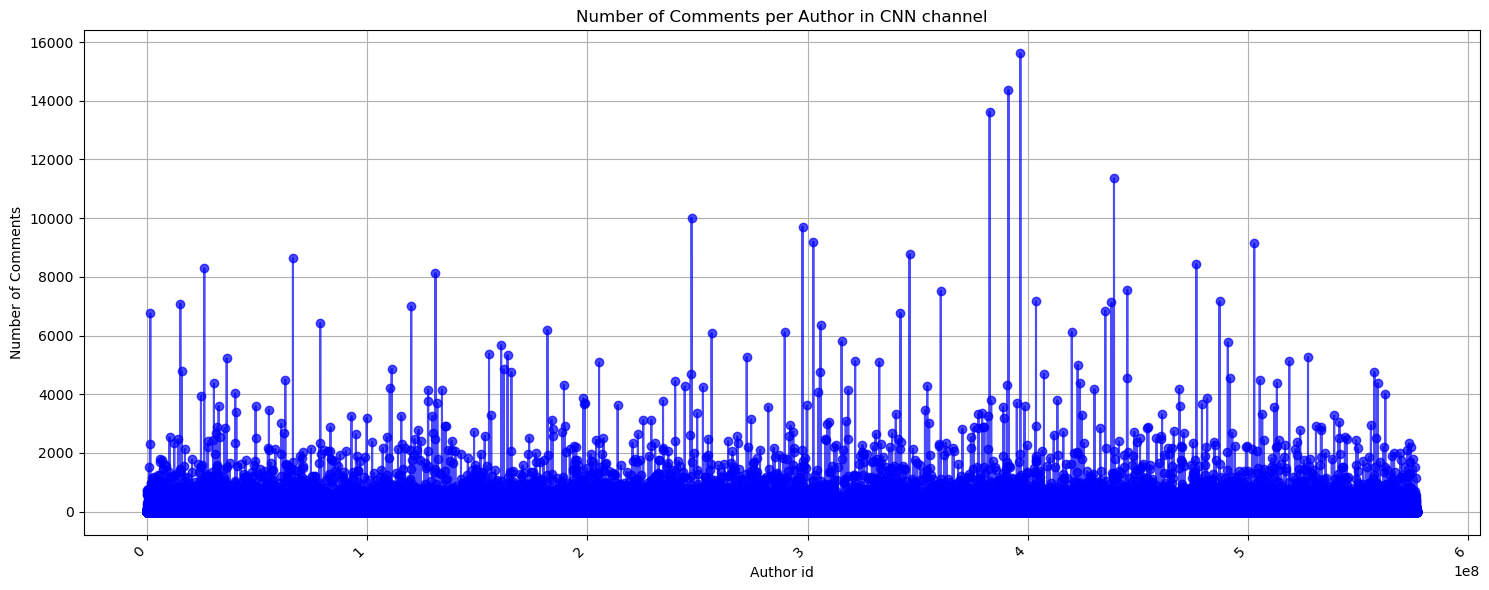

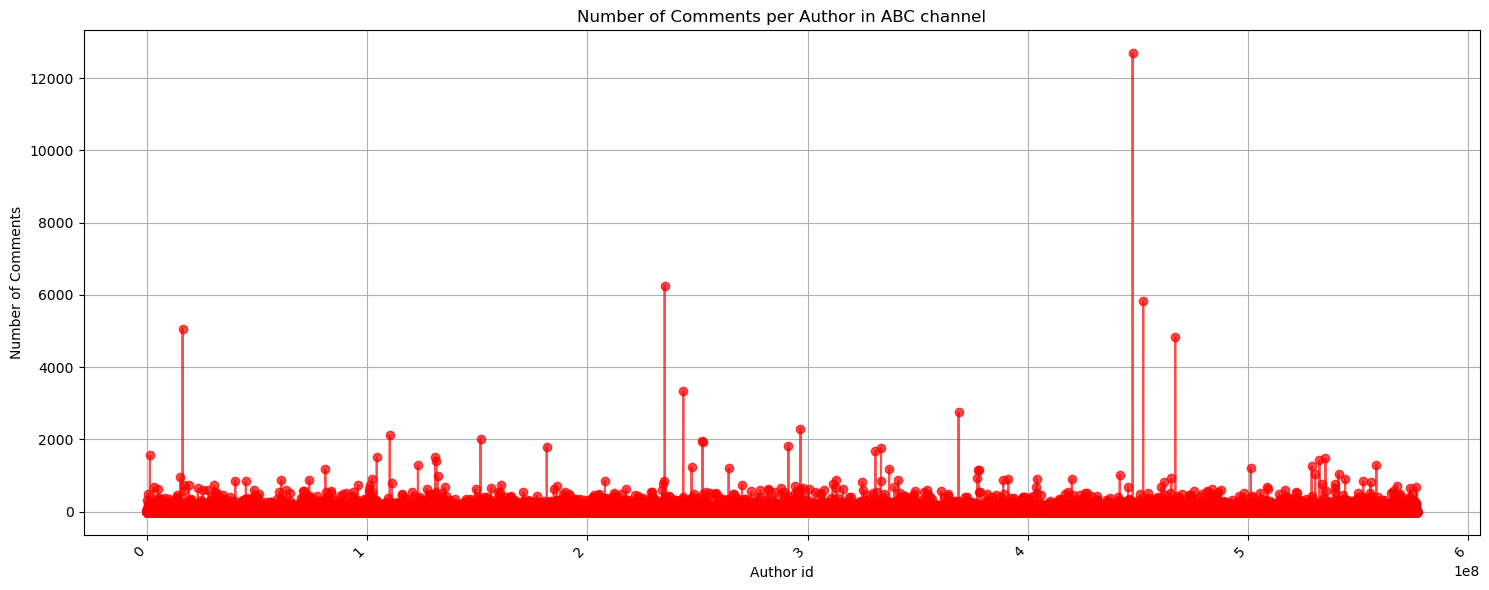

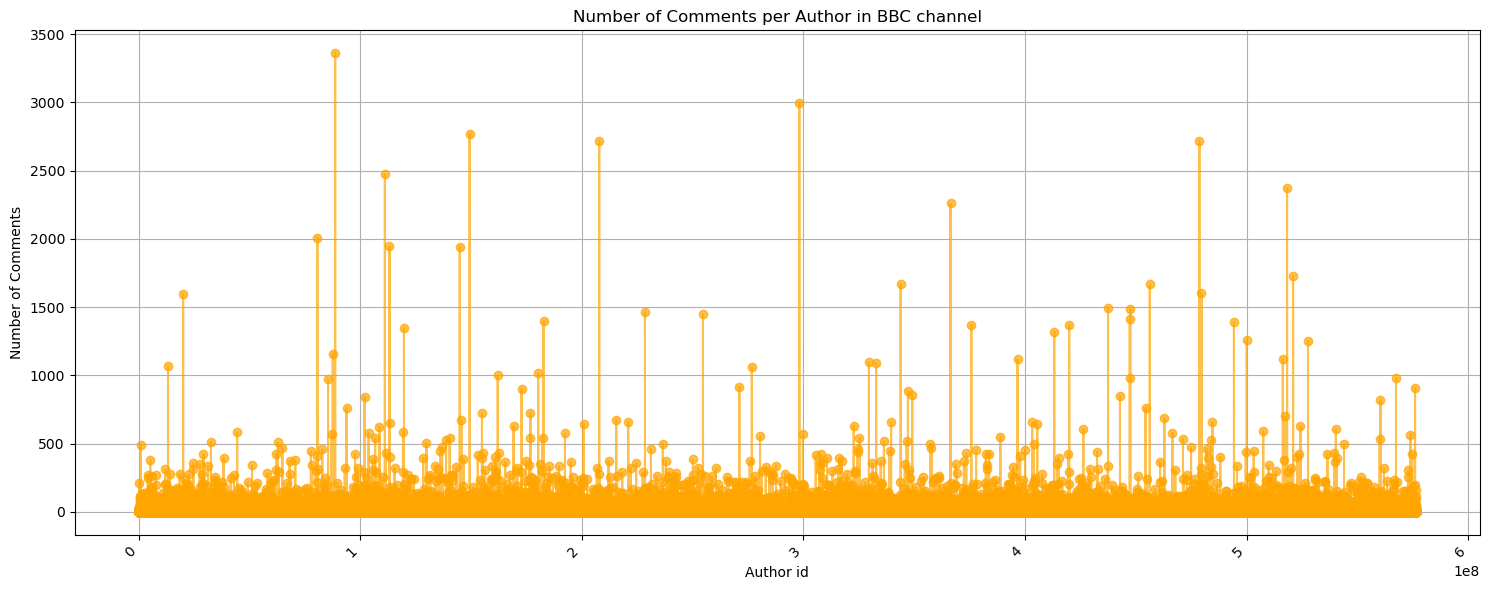

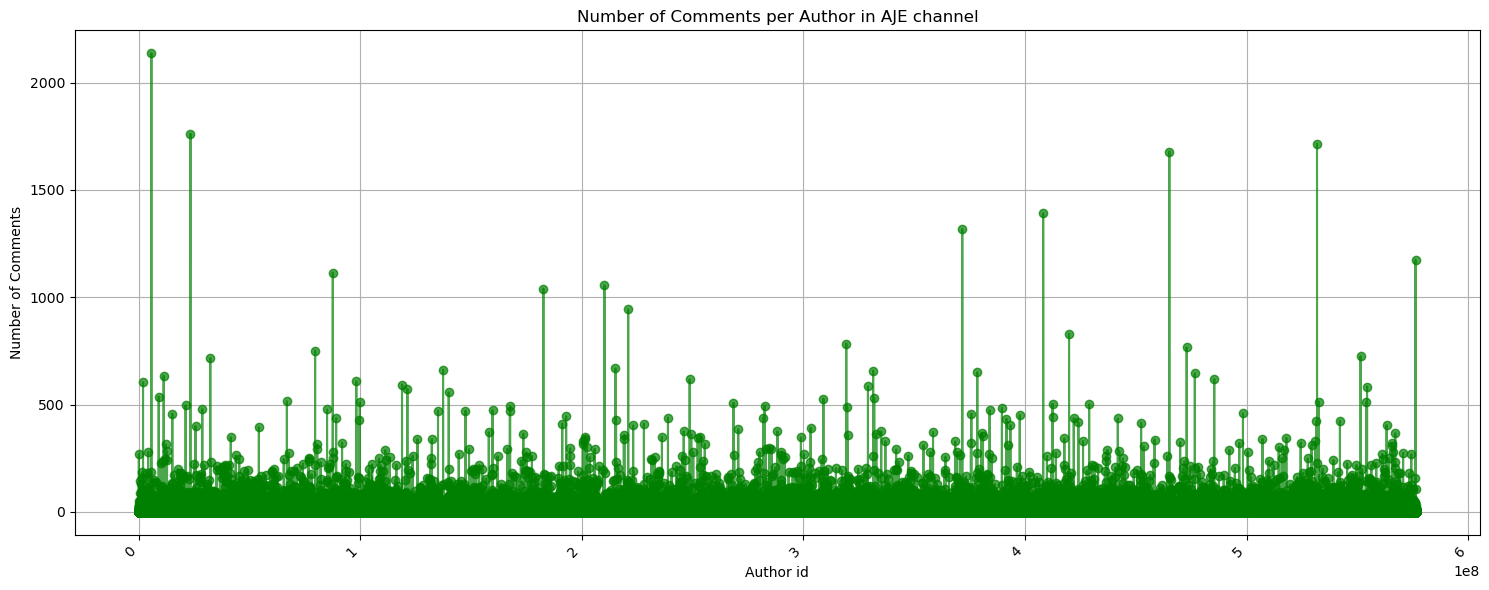

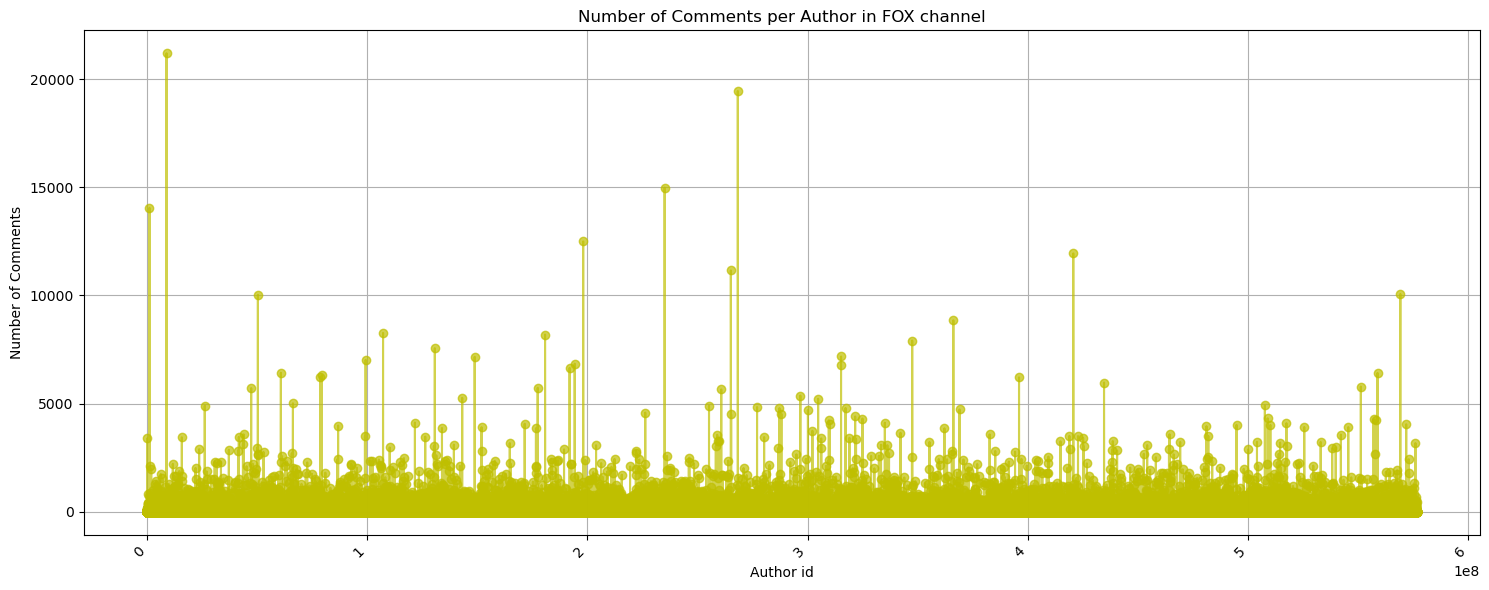

In [8]:
# Grouping by author to get the number of comments per author for each channel
comment_counts_cnn = df_comments_news_pol_cnn.groupby('author').size()
comment_counts_abc = df_comments_news_pol_abc.groupby('author').size()
comment_counts_bbc = df_comments_news_pol_bbc.groupby('author').size()
comment_counts_aje = df_comments_news_pol_aje.groupby('author').size()
comment_counts_fox = df_comments_news_pol_fox.groupby('author').size()



dp.plot_dist_comment(comment_counts_cnn, 'CNN','b')
dp.plot_dist_comment(comment_counts_abc, 'ABC','r')
dp.plot_dist_comment(comment_counts_bbc, 'BBC','orange')
dp.plot_dist_comment(comment_counts_aje, 'AJE','g')
dp.plot_dist_comment(comment_counts_fox, 'FOX','y')

### Analysis 
The distribution of comments per author is extremely broad, with most users writing few comments while some individuals have extraordinarily high comment volumes. Fox News stands out with users who have commented over 20,000 times, while CNN and AJE also have highly active isolated users, albeit with somewhat lower maximal comment values compared to Fox News.

### Comments distribution for the 5 main channels

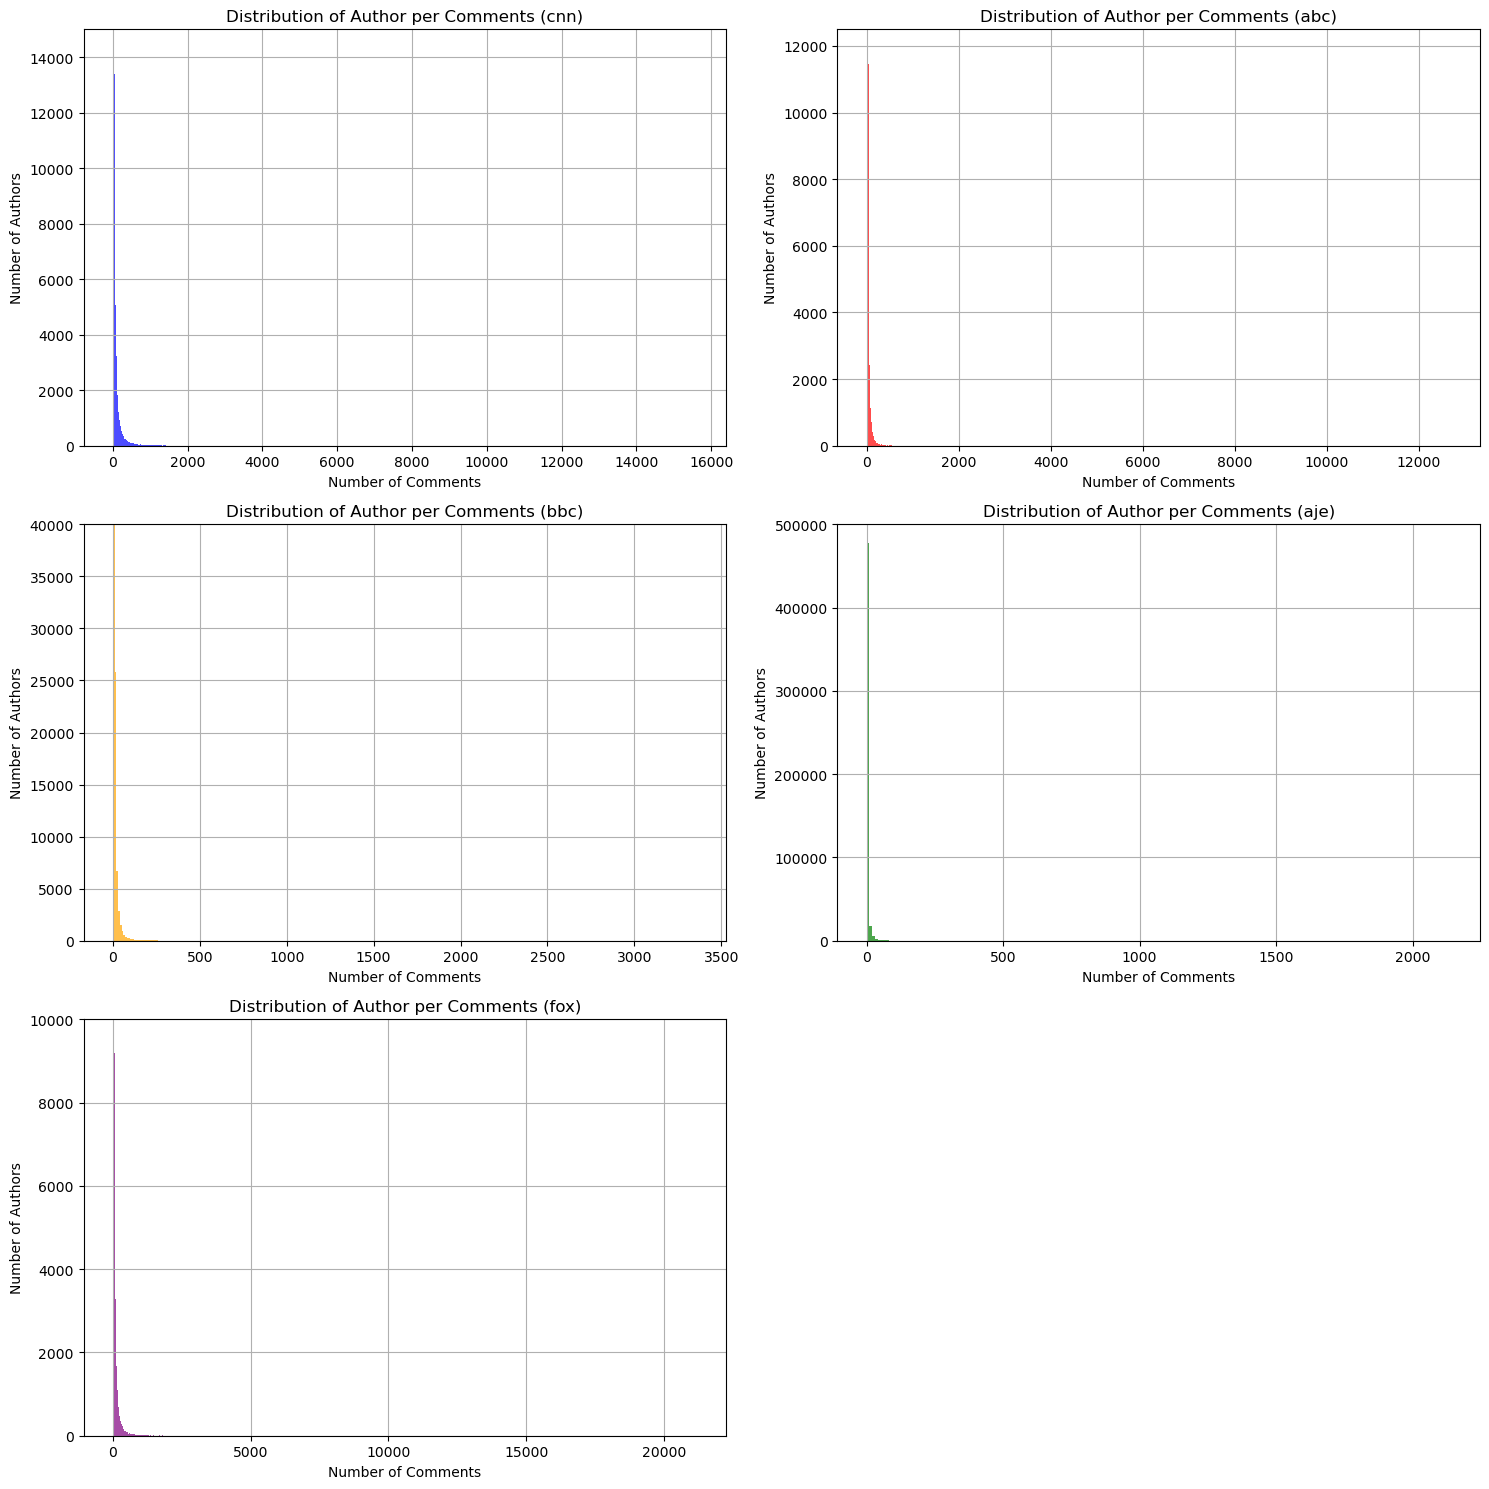

In [14]:
data = [
    (comment_counts_cnn, 'cnn'),
    (comment_counts_abc, 'abc'),
    (comment_counts_bbc, 'bbc'),
    (comment_counts_aje, 'aje'),
    (comment_counts_fox, 'fox')
]
titles = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']
ylims = [15000, 12500, 40000, 500000, 10000]

#plot histo in 'normal' scale
dp.plot_histo_subplot(data, titles, colors, ylims, 2)
    


## Analysis

All the channels exhibit highly skewed distributions, with the key distinction being the range of comment counts across each channel. AJE seems to be the channel with the most users that write a small numbers of comments, and Fox the lowest of such commenters. What stands out in these distributions is that they all have a "long tail", meaning that there exist users posting significantly more comments than the very large majority of users. This suggests that the more active authors can be identified as distinct clusters based on their comment volume.
One can see that Fox users tend to be way more active then others !!


For better visualization, we will plot in log scale :

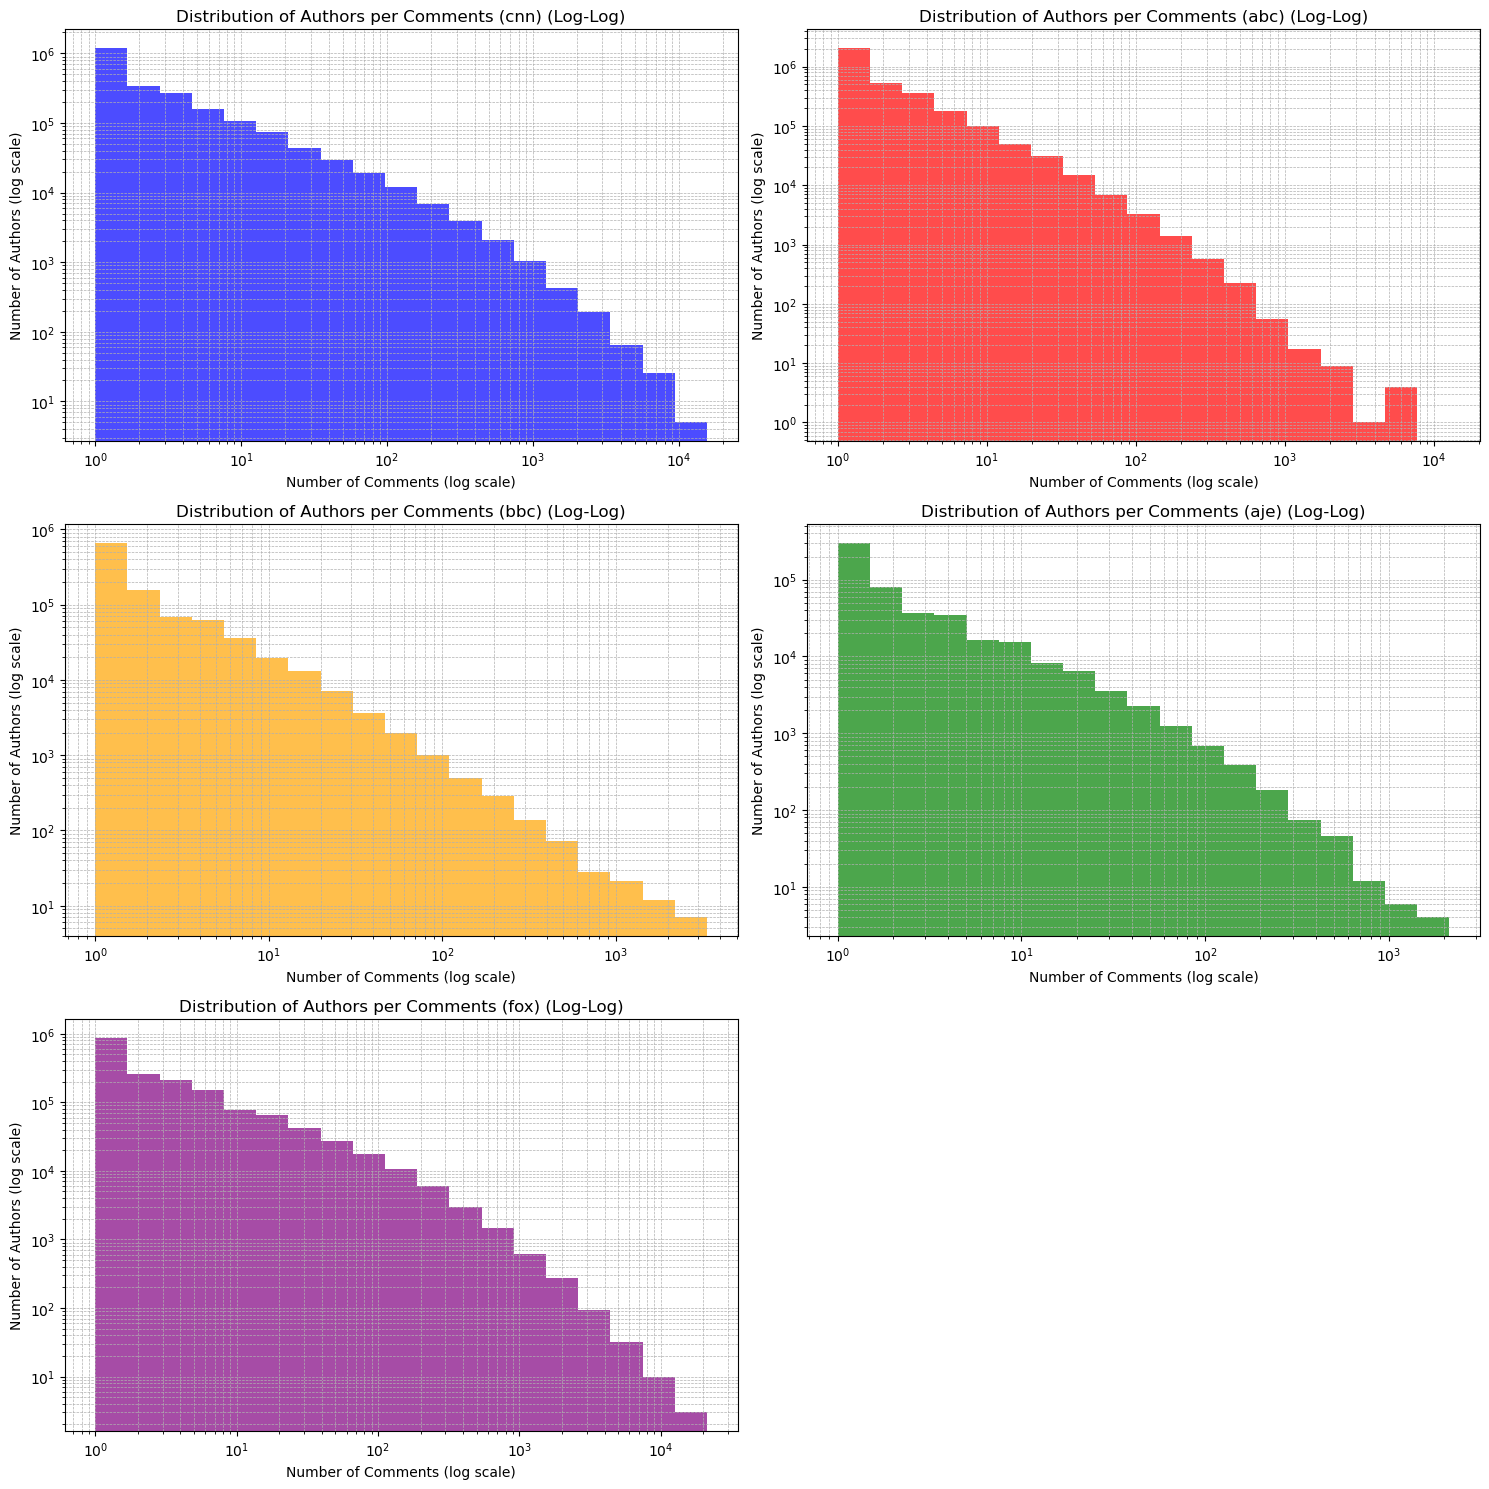

In [15]:
#For each channel
#plot histo in log scale (utils function)
dp.plot_log_histo_subplot(data, titles, colors, 2)


These plots seem to indicate that the distribution is a power law, as the lines in the log log plots are (to a varying degree) close to a straight line! Further analysis should be done to prove this.

# Part 2: Defining cluster

Flexible function where you give the threshold of x comment --> first function towards selecting clusters

This part is not done. Will be finished in P3.


In [131]:
#returns df with users_id and total number of comments made in a specific channel

threshold = 0  # decide this based on the distributions of comments for the 5 channels

metadata_commenters_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/metadata_commenters_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc", "bbc", 
                    "aje", "fox"]
    ]

if np.all([os.path.isfile(filepath) for filepath in metadata_commenters_news_pol_selected_channels_filepaths]):
    metadata_commenters_news_pol_cnn = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[0])
    metadata_commenters_news_pol_abc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[1])
    metadata_commenters_news_pol_bbc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[2])
    metadata_commenters_news_pol_aje = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[3])
    metadata_commenters_news_pol_fox = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:  # calculate the metadata using the threshold defined above
    # group the comments by channel
    # df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (metadata_commenters_news_pol_cnn,
     metadata_commenters_news_pol_abc,
     metadata_commenters_news_pol_bbc,
     metadata_commenters_news_pol_aje,
     metadata_commenters_news_pol_fox) = (dp.get_metadata_commenters(df_comments, threshold)
                                          for df_comments in [df_comments_news_pol_cnn,
                                                              df_comments_news_pol_abc,
                                                              df_comments_news_pol_bbc,
                                                              df_comments_news_pol_aje,
                                                              df_comments_news_pol_fox])
    
    # save the new dfs to csv
    metadata_commenters_news_pol_cnn.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[0], index=False)
    metadata_commenters_news_pol_abc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[1], index=False)
    metadata_commenters_news_pol_bbc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[2], index=False)
    metadata_commenters_news_pol_aje.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[3], index=False)
    metadata_commenters_news_pol_fox.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[4], index=False)



#putting, for now, a randomn thresold to see if function  is working
#testing for cnn channel
#THIS WAS DONE TO VERIFY THE THRESOLD IS WORKING BUT CAN BE DISCARD OR PUT IN NON IMPORTANT STUFF
metadata_commenters_news_pol_cnn_0_filepath = dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn_0.csv"

try:
    metadata_commenters_news_pol_cnn_0 = pd.read_csv(metadata_commenters_news_pol_cnn_0_filepath)
    print("Read data from file")
except FileNotFoundError:
    metadata_commenters_news_pol_cnn_0 = dp.get_metadata_commenters(df_comments_news_pol_cnn,0)
    metadata_commenters_news_pol_cnn_0.to_csv(metadata_commenters_news_pol_cnn_0_filepath, index=False)
    print("Saved data to file")

# display cnn data as an example
display(metadata_commenters_news_pol_cnn_0.head())
# display sizes of all 5 dfs
display(metadata_commenters_news_pol_cnn_0.shape)

#change thresold 
metadata_commenters_news_pol_cnn_500_filepath = dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn_500.csv"
try:
    metadata_commenters_news_pol_cnn_500 = pd.read_csv(metadata_commenters_news_pol_cnn_500_filepath)
    print("Read data from file")
except FileNotFoundError:
    metadata_commenters_news_pol_cnn_500 = dp.get_metadata_commenters(df_comments_news_pol_cnn,500)
    metadata_commenters_news_pol_cnn_500.to_csv(metadata_commenters_news_pol_cnn_500_filepath, index=False)
    print("Saved data to file")

# display cnn data as an example
display(metadata_commenters_news_pol_cnn_500.head())
# display sizes of all 5 dfs
display(metadata_commenters_news_pol_cnn_500.shape)


Read data from file


,author,number_of_comments,number_of_videos
0,269,1,1
1,1015,1,1
2,1548,2,1
3,1560,2,1
4,2097,3,2


(2268335, 3)

Read data from file


,author,number_of_comments,number_of_videos
0,97609,737,631
1,139895,687,581
2,155881,610,334
3,159530,567,384
4,374746,756,656


(3257, 3)

Functions works for the two thresold : 0 and 500, returning different amounts of users, as expected.

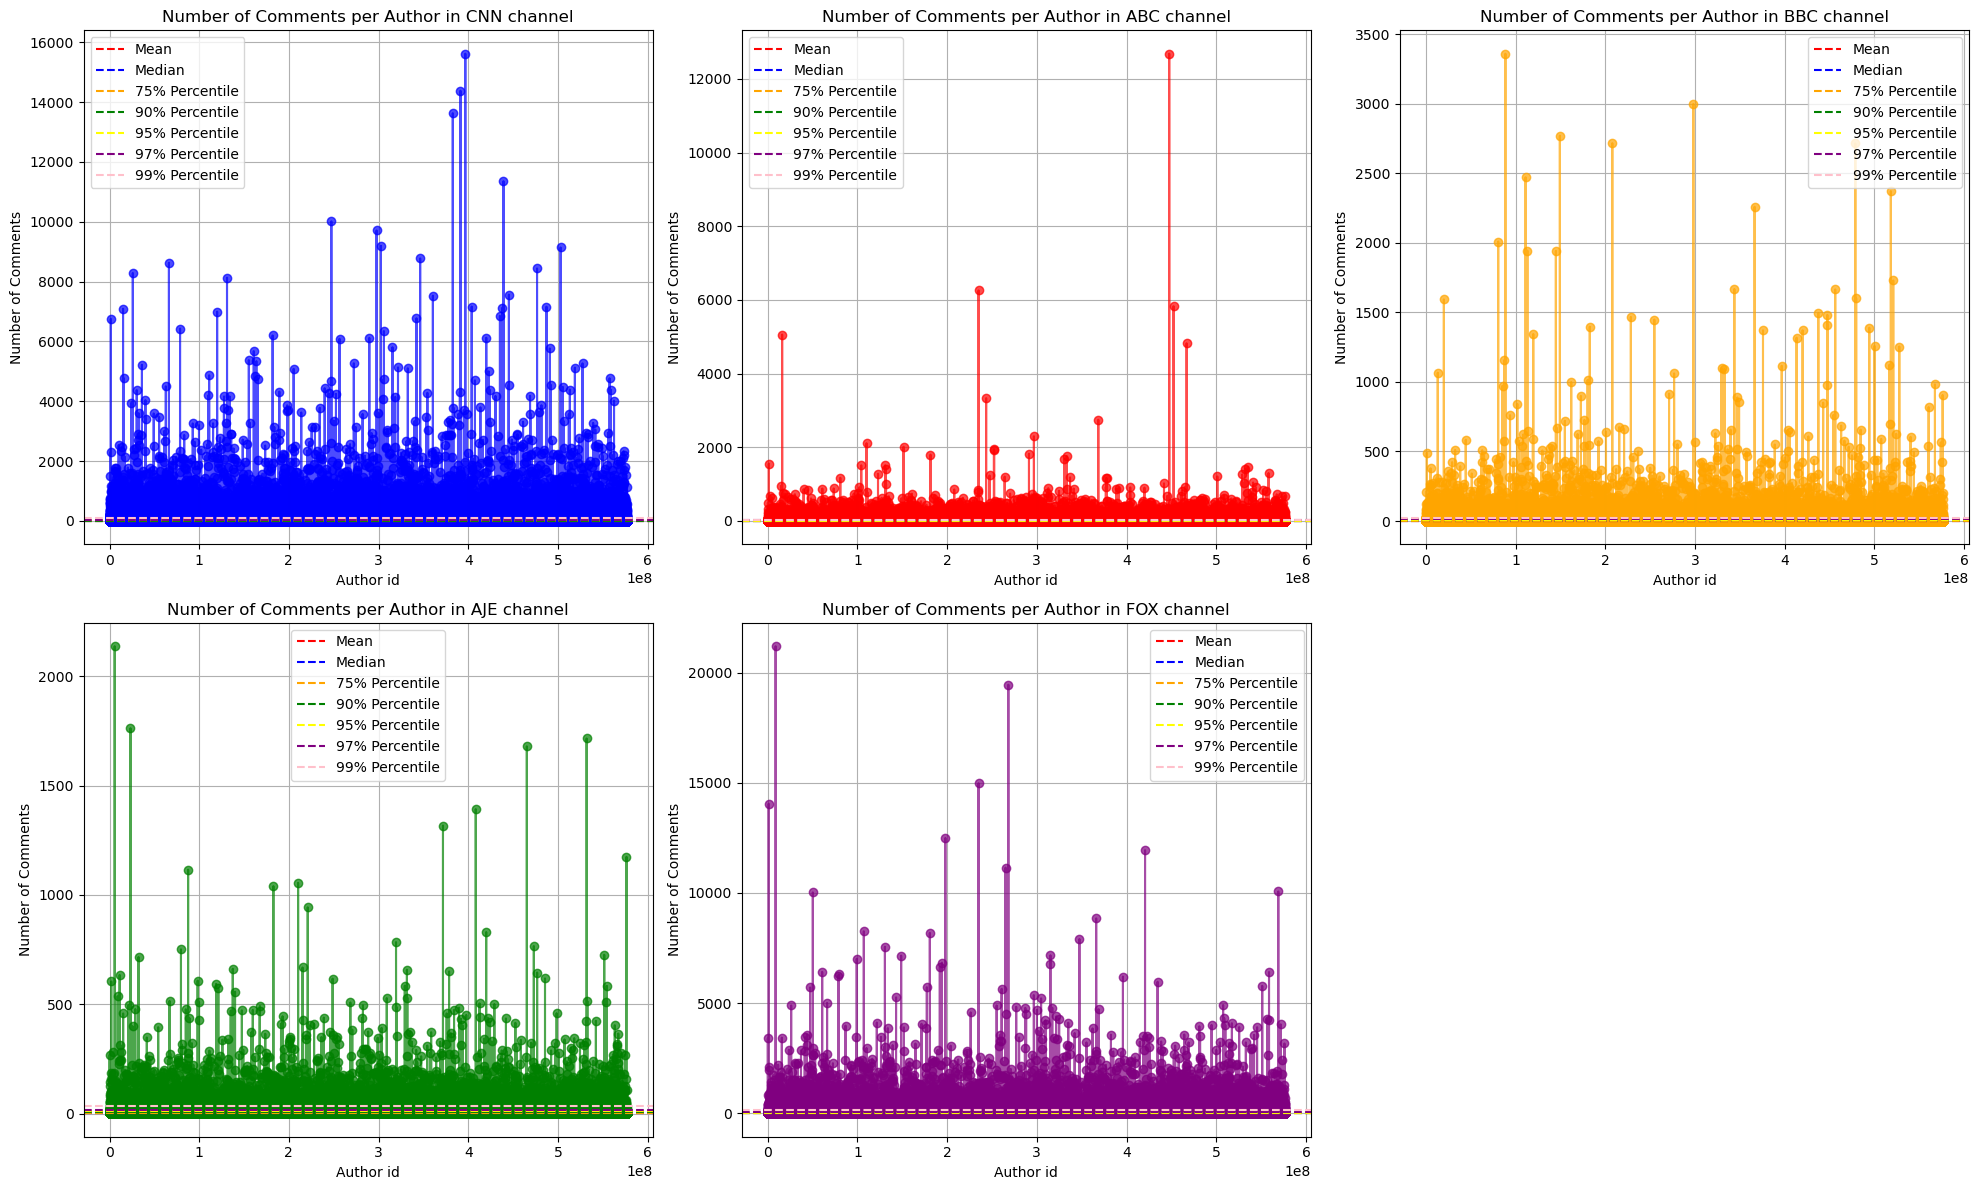

,Mean,Median,75% Percentile,90% Percentile,95% Percentile,97 % Percentile,99% Percentile
cnn,299899,2268335,728636,245623,114279,69177,22895
abc,741751,3322207,1264223,385206,177284,107551,33499
bbc,214495,1028344,370396,107853,55840,31135,10464
aje,89708,506417,126660,54892,25821,16083,5250
fox,230079,871759,484027,174226,89201,52211,17372


In [132]:
#this cell is defining different thresold (median, mean, 95th,99th percentile), and calculating the numbers of users above this number
#the aim is to define which thresold we will take for the cluster (e.g. take 1% top users of cnn that have the most commented)


# Threshold DETERMINATION

#make figure for visualisation for each channel (thus subplot)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# List of 5 main channels
channels = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']

# Dictionary to store metadata for each channel
metadata_dict = {}

# Different types of threshold
thresholds_df = pd.DataFrame(columns=["Mean", "Median", "75% Percentile", 
                                      "90% Percentile" ,"95% Percentile" , 
                                      "97 % Percentile", "99% Percentile"], index=channels)


for idx, channel in enumerate(channels):
    metadata_dict[channel] = {}

    # Get metadata and comment counts for each channel
    metadata_dict[channel]['metadata'] = globals()[f'metadata_commenters_news_pol_{channel}']
    metadata_dict[channel]['comment_counts'] = globals()[f'comment_counts_{channel}']

    # Calculate thresholds for each channel
    mean_channel = metadata_dict[channel]['metadata'].number_of_comments.mean()
    median_channel = metadata_dict[channel]['metadata'].number_of_comments.median()
    percentile_75 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.75)
    percentile_90 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.9)
    percentile_95 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.95)
    percentile_97 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.97)
    percentile_99 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.99)

    # Number of users above the threshold for each channel
    metadata_dict[channel]['metadata_mean'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], mean_channel)
    metadata_dict[channel]['metadata_median'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], median_channel)
    metadata_dict[channel]['metadata_percentile_75'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_75)
    metadata_dict[channel]['metadata_percentile_90'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_90)
    metadata_dict[channel]['metadata_percentile_95'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_95)
    metadata_dict[channel]['metadata_percentile_97'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_97)
    metadata_dict[channel]['metadata_percentile_99'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_99)

    thresholds_df.loc[channel] = [
        len(metadata_dict[channel]['metadata_mean']),
        len(metadata_dict[channel]['metadata_median']),
        len(metadata_dict[channel]['metadata_percentile_75']),
        len(metadata_dict[channel]['metadata_percentile_90']),
        len(metadata_dict[channel]['metadata_percentile_95']),
        len(metadata_dict[channel]['metadata_percentile_97']),
        len(metadata_dict[channel]['metadata_percentile_99'])]
    
    # Plotting the number of comments per author for each channel
    axes[idx].plot(metadata_dict[channel]['comment_counts'].index, metadata_dict[channel]['comment_counts'], marker='o', color=colors[idx], alpha=0.7)
    axes[idx].set_title(f'Number of Comments per Author in {channel.upper()} channel')
    axes[idx].set_xlabel('Author id')
    axes[idx].set_ylabel('Number of Comments')
    axes[idx].grid(True)
    axes[idx].axhline(y=mean_channel, color='r', linestyle='--', label='Mean')
    axes[idx].axhline(y=median_channel, color='b', linestyle='--', label='Median')
    axes[idx].axhline(y=percentile_75, color='orange', linestyle='--', label='75% Percentile')
    axes[idx].axhline(y=percentile_90, color='green', linestyle='--', label='90% Percentile')
    axes[idx].axhline(y=percentile_95, color='yellow', linestyle='--', label='95% Percentile')
    axes[idx].axhline(y=percentile_97, color='purple', linestyle='--', label='97% Percentile')
    axes[idx].axhline(y=percentile_99, color='pink', linestyle='--', label='99% Percentile')
    axes[idx].legend()


plt.tight_layout()
axes[5].axis('off')
plt.show()



display(thresholds_df)


We will take the thresold :99th percentile, as it is already a big set of users. It is statistically relevant because it is taking the most active 1% users for each channels. 

In [56]:
#generate the clusters for each channel, taking only the 1% top users
#cluster 

filepath_cnn_cluster= dataset_root_path + "../generated_data/cluster_cnn.csv"
filepath_abc_cluster= dataset_root_path + "../generated_data/cluster_abc.csv"
filepath_bbc_cluster= dataset_root_path + "../generated_data/cluster_bbc.csv"
filepath_aje_cluster= dataset_root_path + "../generated_data/cluster_aje.csv"
filepath_fox_cluster= dataset_root_path + "../generated_data/cluster_fox.csv"

try:
    cluster_cnn = pd.read_csv(filepath_cnn_cluster)
    print("Read data cnn from file")
    cluster_abc = pd.read_csv(filepath_abc_cluster)
    print("Read data abc from file")
    cluster_bbc = pd.read_csv(filepath_bbc_cluster)
    print("Read data bbc from file")
    cluster_aje = pd.read_csv(filepath_aje_cluster)
    print("Read data aje from file")
    cluster_fox = pd.read_csv(filepath_fox_cluster)
    print("Read data fox from file")
except: 

    cluster_cnn = metadata_dict['cnn']['metadata_percentile_99']
    cluster_abc = metadata_dict['abc']['metadata_percentile_99']
    cluster_bbc = metadata_dict['bbc']['metadata_percentile_99']
    cluster_aje = metadata_dict['aje']['metadata_percentile_99']
    cluster_fox = metadata_dict['fox']['metadata_percentile_99']

    
    cluster_cnn.to_csv(filepath_cnn_cluster, index=False)
    cluster_abc.to_csv(filepath_abc_cluster, index=False)
    cluster_bbc.to_csv(filepath_bbc_cluster, index=False)
    cluster_aje.to_csv(filepath_aje_cluster, index=False)
    cluster_fox.to_csv(filepath_fox_cluster, index=False)

    print("Wrote cluster data to 5 files.")

    
display(cluster_cnn, cluster_abc, cluster_bbc, cluster_aje, cluster_fox)

Read data cnn from file
Read data abc from file
Read data bbc from file
Read data aje from file
Read data fox from file


,author,number_of_comments,number_of_videos
0,13221,292,3
1,17554,128,56
2,33093,233,94
3,97609,737,631
4,139895,687,581
...,...,...,...
22890,576458921,200,180
22891,576489820,171,7
22892,576498535,153,124
22893,576498815,1138,405


,author,number_of_comments,number_of_videos
0,13217,48,23
1,16863,65,30
2,17554,42,23
3,33985,53,37
4,52185,37,25
...,...,...,...
33494,576456683,168,122
33495,576457863,73,29
33496,576472312,33,2
33497,576517277,164,114


,author,number_of_comments,number_of_videos
0,38628,31,24
1,155881,209,87
2,157971,29,16
3,216669,26,8
4,242788,38,28
...,...,...,...
10459,576457863,39,18
10460,576481725,27,9
10461,576498815,156,58
10462,576504620,25,13


,author,number_of_comments,number_of_videos
0,83683,37,24
1,97609,269,243
2,174608,51,47
3,511454,50,12
4,540267,52,42
...,...,...,...
5245,575956805,42,40
5246,576016221,48,28
5247,576164605,159,82
5248,576277001,1174,382


,author,number_of_comments,number_of_videos
0,110797,176,98
1,155881,3402,1633
2,229428,146,111
3,232887,153,139
4,242318,834,495
...,...,...,...
17367,576357157,694,603
17368,576456683,290,230
17369,576515899,245,15
17370,576519517,242,229


In [57]:
del metadata_dict
print(gc.collect())

0


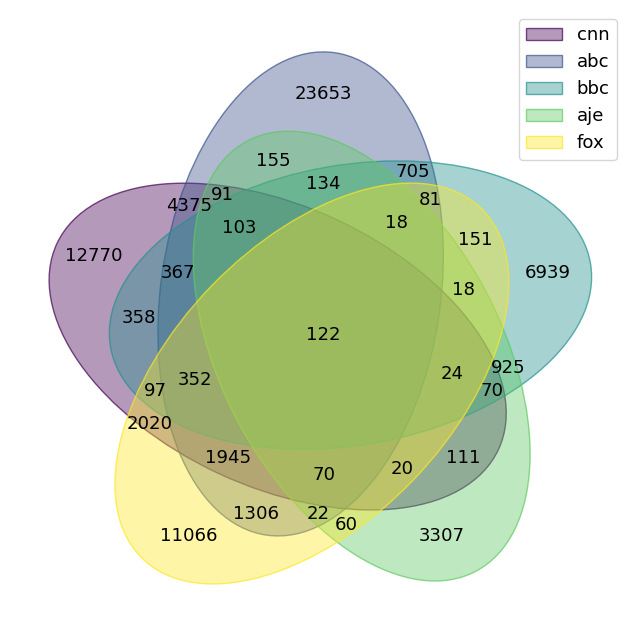

In [58]:
#Venn diagram, in order to see if some authors are in both of some clusters

#venn is a library that take a numbers of set and manipulate it to do a venn diagram of more than 3 sets (matplotlib only do up to 3 sets)
import venn
%matplotlib inline
#define set of users because that's what venn diagram take 
set_cnn = set(cluster_cnn.author)
set_abc = set(cluster_abc.author)
set_bbc = set(cluster_bbc.author)
set_aje = set(cluster_aje.author)
set_fox = set(cluster_fox.author)
sets = {
    "cnn": set_cnn,
    "abc": set_abc,
    "bbc": set_bbc,
    "aje": set_aje,
    "fox": set_fox
}

venn.venn(sets)
plt.show()

### Analysis
One can see that only 122 users are the most active in all 5 channels! Some other overlaps between channels can be seen, but there is still a high number of users that are specific to only one.


# Part 3 : Identifying bubbles

## Determining the mean pairwise overlap of commented videos for users in our clusters

Here, we are going to get, for each defined cluster, for each pair of users in the clusters, the lists of videos they have commented on. Then we compare these lists to get the common elements, i.e. videos on which both paired users have commented on. We can then divide this by the shortest length among the two lists of videos, thereby getting the fraction of commented videos the paired users have in common. We call this "pairwise overlap of commented videos".

Then, we can for instance calculate the mean pairwise overlap for all users in each cluster, and compare this among the clusters. In particular, we can use a random sample of YouTube users, define it as a control cluster, and calculate its the mean pairwise overlap as well. By comparing the control mean overlap to the values for each of our original clusters, we can see whether we have a higher mean for users that commented frequently under a specific channel than for a random reference sample of users; suggesting that they might have a larger overlap in their interests or at least YouTube watching behaviour.

### Getting the required data

*OLD TEXT AND FUNCTION, WE DON'T REALLY NEED IT ANYMORE*

First, we will need to get for every clustered user the list of video they have commented on.

For this, we have the below function, which takes a dataframe with comment data and a list of users, and returns a dataframe containing one column with the user ids and one column with the lists of videos on which the corresponding user has commented on.

There are however too many comments in news and politics videos to be handled at once, so it needs to be done in chunks. Combining the video lists from the different chunks to a single dataframe still needs to be implemented. But, we show that the function below works on a single dataframe by running it on the first chunk of the cnn comment data.


In [59]:
def get_video_list_for_given_users(comment_data: pd.DataFrame, users: pd.DataFrame, video_ids: pd.DataFrame)-> pd.DataFrame:
    """
    Creates a df with one column for users 
    and one column with the list of videos that user has commented on.
    Args:
        comment_data: a df containing the comments to go through
        users: the list of users to do this for
        
    Returns:
        df as described above
    """
    
    comments_by_given_users_grouped = comment_data.loc[comment_data.author.isin(users)].groupby("author")
    video_ids_of_comments_by_given_users_grouped = comments_by_given_users_grouped['video_id']

    return pd.DataFrame({'author': video_ids_of_comments_by_given_users_grouped.groups.keys(), 
                         'video_list': [comment_data.loc[vid_ids].video_id for vid_ids in video_ids_of_comments_by_given_users_grouped.groups.values()]})


video_list_for_cnn_cluster__chunk_1_filename = dataset_root_path + "../generated_data/video_list_cnn_cluster_chunk_1.json"

if os.path.isfile(video_list_for_cnn_cluster__chunk_1_filename):
    df_video_list_for_cnn_cluster_chunk_1 = pd.read_json(video_list_for_cnn_cluster__chunk_1_filename)
else:
    for i, df_comments_news_pol_chunk in enumerate(pd.read_csv(comments_news_pol_videos_filepath, chunksize=1000000)):
        if i > 0:
            break
        df_video_list_for_cnn_cluster_chunk_1 = get_video_list_for_given_users(df_comments_news_pol_chunk, df_comments_news_pol_cnn.author, df_videos_news_pol_display_ids)
        
        df_video_list_for_cnn_cluster_chunk_1.to_json(video_list_for_cnn_cluster__chunk_1_filename, index=False)
        
    
display(df_video_list_for_cnn_cluster_chunk_1)

,author,video_list
0,269,68 1TV6JFxMEcI 69 BuQBRtxw-CY 70 anah...
1,1015,219 b8Jmjloz9_k 220 slXbw677sEY Name: vi...
2,1548,336 -rN17xNnIyM 337 -rN17xNnIyM 338 a...
3,1560,345 LHoQm8LxEmQ 346 LHoQm8LxEmQ 347 L...
4,2097,421 IwczRAkQsB4 422 5Mp8PNm25gk 423 W...
...,...,...
5671,1408976,999259 fkSNyrByMQw 999260 A2nklduvThs 99...
5672,1409369,999391 cTwxnUKhF5I 999392 CvnmSRghdow 99...
5673,1409488,999557 3X59ndYGMqU 999558 6YRs-x7LPmU 99...
5674,1409658,999830 wRO9BHbF9GA 999831 ACUmAmWaKbg 99...


It's difficult to make a dataframe with the video ids as rows, the user ids as columns, and the entries as booleans showing whether the user has commented on the video, even though it would be a useful format; as this dataframe would be far too big for the amount of videos and users we're considering at this stage.

But, we can save this information in a sparse matrix instead! This matrix contains only stores those values which are True (the case when a user *has* commented on a video), and all other entries are implied to be False. As any user will only have commented on a small fraction of all News and politics videos, this will take far less memory.

In [60]:
def get_video_user_comment_matrix(comment_data: pd.DataFrame, users: pd.DataFrame, print_time_every: int = 0)-> pd.DataFrame:
     """
     Creates a df with video ids as rows, user ids as columns, and the entries being booleans showing whether the user has commented.
     and one column with the list of videos that user has commented on.
     Args:
         comment_data: a df containing the comments to go through. 
             Video_id must be integers, corresponding to the assumed ordering of video ids in the matrix!
             (So for example, you would have to change video ids ['abc', 'xyz', 'pqr'] to [0, 1, 2], 
             and then change the video id column in the comment data to show, 0, 1, or 2 instead of 'abc', 'xyz' or 'pqr')
         users: the list of users to do this for. The user ids MUST be integers corresponding to their respective columns in the matrix
     Returns:
         df as described above
     """

     comments_by_given_users_grouped = comment_data.loc[comment_data.author.isin(users)].groupby("author")
     video_ids_of_comments_by_given_users_grouped = comments_by_given_users_grouped['video_id']
 
     rows = []
     cols = []
     time_duration_avg = 0
     for i, (user, vid_indices) in enumerate(video_ids_of_comments_by_given_users_grouped.groups.items()):
         time_start = time.time()

        # new row ids are the video ids of the videos the user has commented on
         new_row_ids = comment_data.loc[vid_indices].video_id.values
         rows.extend(new_row_ids)

        # new col ids are simply the column corresponding to the current user. That's why the user id's must correspond to their column ids!
         cols.extend([user] * len(new_row_ids))
        
        
         time_end = time.time()
         # Some timing stuff, not used anymore since the code has gotten fast enough
         if not not print_time_every:
             time_duration = time_end - time_start
             time_duration_avg = (time_duration_avg * i + time_duration) / (i+1)
             time_left_in_chunk_avg = (len(video_ids_of_comments_by_given_users_grouped.groups) - i) * (time_duration_avg)
             if i % print_time_every == 0:
                 print(f"    User {i} of {len(video_ids_of_comments_by_given_users_grouped.groups)}: {time_duration:.3f} s ({time_duration_avg:.3f} s avg)   |   " 
                     + f"{time_left_in_chunk_avg:.3f} s ({time_left_in_chunk_avg / 60:.3f} min) left.")

     return rows, cols

For this, there is now a function in the utils file called 'get_video_user_entry_data_for_chunk', which takes comment data and a list of users (i.e., a cluster), and returns the raw data needed to create a sparse boolean matrix where each entry $(i,j)$ indicates whether user $j$ has commented on video $i$.

"Raw data" in this case means: A list of row indices and a list of column entries. The sparse matrix will then be formed such that each pair $(row[k], col[k])$ is a True entry.

However this function only works on single dataframes of comment data, and our comment data (all comments under videos in News and politics) is too big, and we need to read it in chunks.

There is a function 'get_video_user_matrix' in the utils file as well which does this automatically.

There are also further preparation steps which needs to be done, as the functions don't work with the normal video_ids and user_ids; instead they require the id's to correspond to the column and row ids in the matrix.
For example: If the video with id "eh743jss" is in row 312 of the matrix, then the video_id given in the comment data should not be "eh743jss" as it was originally, but it should instead be 312.

(The reason for this is that otherwise, the functions would need to do very time-consuming operations, because for every video they would need to look up in which row it should put a True value. Now instead, it can just put the true value in the row corresponding to the index, no lookup needed)

This is all shown in an example below:

In [61]:
# We create test datasets, to show how the function dp.get_video_user_entry_data_for_chunk works:

# here are a bunch of comments, users and videos we will look at
comments_test = pd.DataFrame({'author':[1, 2, 3, 1, 5, 4, 1], 
                              'video_id':['a', 'b', 'c', 'd', 'e', 'f', 'a']})

users_test = pd.DataFrame({'author': [1, 2, 3, 5]})  
# note that one of the users in the comment data is not part of the user list. This corresponds e.g. to the comment data containing data about comments that were written by someone not in our cluster

videos_test = pd.DataFrame({'display_id': ['a', 'b', 'c', 'd', 'e', 'f']})

print('comments')
display(comments_test)
print('users')
display(users_test)
print('videos')
display(videos_test)

comments


,author,video_id
0,1,a
1,2,b
2,3,c
3,1,d
4,5,e
5,4,f
6,1,a


users


,author
0,1
1,2
2,3
3,5


videos


,display_id
0,a
1,b
2,c
3,d
4,e
5,f


Note that the function above requires the user ids and video ids to correspond to the row and column id's in the matrix

Normally, this will not be the case, for instance, the video ids in the dataset are strings, and while the user ids
are integers, they don't start with 1, and alo we only care about the users in our cluster, so we don't want a column
for other users in our matrix, meaning that we need to assign new indices for the users, 
going from 0 to [number of users in cluster]

This is also true for our example data above, where the display id's are strings and the user id's start at 1, and user 5 is not included in our user list although a comment by user 5 is in the comment data.

Therefore, we are doing a re-indexing:

In [62]:
# take all the available display_ids, remove any duplicates, 
# create a new int index starting from 0, then set the old display id's as index
videos_test_display_id_mapping = (videos_test.display_id  # take the current display ids
    .drop_duplicates()  # remove any diplicates if there are some
    .reset_index(drop=True)  # create a new index which goes from 0 to number of authors (this is stored in the index) (we don't need the old index, so drop=True)
    .reset_index()  # reset index again, in order to move the just created index into a column (with name 'index')
    .set_index(['display_id'])['index'] # set the old display id to be the index, select the new index column
    )  

# This gives a Series which maps each old display id (which is the index of the series) to a new index 
# (which are the values of the Series)
# It looks like this:
print("Video id to int mapping:")
display(videos_test_display_id_mapping)

# Now do the same for user ids and display (take all users in the user list (e.g. a cluster) and give them nice indices)
users_test_user_id_mapping = (users_test.author
                              .drop_duplicates()
                              .reset_index(drop=True)
                              .reset_index()
                              .set_index(['author'])['index']
                              )

print("User id to int mapping:")
display(users_test_user_id_mapping)

# There is a function in the utils file which does this automatically:

videos_test_display_id_mapping = dp.get_int_mapping(videos_test.display_id)
users_test_user_id_mapping = dp.get_int_mapping(users_test.author)

print("Video id to int mapping:")
display(videos_test_display_id_mapping)
print("User id to int mapping:")
display(users_test_user_id_mapping)

Video id to int mapping:


display_id
a    0
b    1
c    2
d    3
e    4
f    5
Name: index, dtype: int64

User id to int mapping:


author
1    0
2    1
3    2
5    3
Name: index, dtype: int64

Video id to int mapping:


display_id
a    0
b    1
c    2
d    3
e    4
f    5
Name: index, dtype: int64

User id to int mapping:


author
1    0
2    1
3    2
5    3
Name: index, dtype: int64


Now we can use these mappings to change the user and video ids in our example datarames:

In [63]:
comments_test.author = comments_test.author.map(users_test_user_id_mapping).dropna().astype(int)  # correct the user ids in comment data
users_test.author = users_test.author.map(users_test_user_id_mapping).dropna().astype(int)  # correct the user ids in the user list
comments_test.video_id = comments_test.video_id.map(videos_test_display_id_mapping)  # correct the video ids in the comment df
videos_test.display_id = videos_test.display_id.map(videos_test_display_id_mapping)  # correct the video ids in the video df

# Look at the results, now we have correct indices!
display(comments_test)
display(users_test)
display(videos_test)

,author,video_id
0,0.0,0
1,1.0,1
2,2.0,2
3,0.0,3
4,3.0,4
5,NaN,5
6,0.0,0


,author
0,0
1,1
2,2
3,3


,display_id
0,0
1,1
2,2
3,3
4,4
5,5


Note that in the comment data, we now have a NaN value, and the numbers are now numpy floats instead of integers.
This both comes from the fact that our mapping does not include a value for user 5, as we don't want to consider this user, and therefore they will not get a column in the matrix. 

So this is not a problem, we only have to consider later to convert float values to ints (we cannot do it now, beause NaN is not an int)

In [64]:
# we then use the function to get the indices of rows and columns where we will later set the value to "true":
# that means, we get an array of row indices and an array of column indices, and then always the first row index 
# with the first column index specify a location of a true value, i.e., a video (=row) which has been commented by a user (column)

test_rows_and_cols = dp.get_video_user_entry_data_for_chunk(comment_data=comments_test, users=users_test.author)
display(test_rows_and_cols[0])  # row indices
display(test_rows_and_cols[1])  # column indices

# so in this case, the points (0, 0), (3, 0), (0, 0), (1, 1), (2, 2), (5, 3) will get true values in our matrix
# meaning that user 0 has commented video 0 twice and video 3 once; user 1 has commented video 1, 
# user 2 has commented video 2, user 3 has commented video 5

[0, 3, 0, 1, 2, 4]

[0.0, 0.0, 0.0, 1.0, 2.0, 3.0]

Note that these indices (when we are talking about "user 1" has commented "video 1" etc) are of course our new indices!

We will see two notebook cells further down that they correspond to the matrix entries, as expected.

If we want to get back the original indices, we can reverse the indexing mapping again.
But right now, we don't really need that. Because we are looking for mean pairwise overlap, so what we call the users
and the videos is not important, we just want to know how many videos they generally have in common.

But if we want to do it (for example, later on it might be important to look at which video it actually was) then it can be done like this:

In [65]:
test_rows_original_index = pd.Series(test_rows_and_cols[0]).map({new_ind:display_id for display_id, new_ind in videos_test_display_id_mapping.items()}).to_numpy()

display(test_rows_original_index)

test_cols_original_index = pd.Series(test_rows_and_cols[1]).map({new_ind:user_id for user_id, new_ind in users_test_user_id_mapping.items()}).to_numpy()

display(test_cols_original_index)

# There is also a function for this in the utils file:
test_rows_original_index = pd.Series(test_rows_and_cols[0]).map(dp.get_inverse_int_mapping(videos_test_display_id_mapping)).to_numpy()
test_cols_original_index = pd.Series(test_rows_and_cols[1]).map(dp.get_inverse_int_mapping(users_test_user_id_mapping)).to_numpy()

display(test_rows_original_index)
display(test_cols_original_index)

array(['a', 'd', 'a', 'b', 'c', 'e'], dtype=object)

array([1, 1, 1, 2, 3, 5])

array(['a', 'd', 'a', 'b', 'c', 'e'], dtype=object)

array([1, 1, 1, 2, 3, 5])

So this would instead give the row, col pairs (a, 1), (d, 1), (a, 1), (b, 2), (c, 3), (f, 4)

Whis is more easily interpretable as "video a has been commented on by user 1 twice, video d has been commented on by user 1, etc."

In [66]:
# Now we go back to use our row and column data for the "new" indices (the int indices) to generate our sparse matrix 
# (the matrix is basically stored using these lists of row and column indices, 
# any entry corresponding to such an index pair is considered "True", any other entry is "False" 
# (and therefore doesn't have to be stored explicitly)

# first we need a vector containing our matrix data. In this case, all of our data is "True", 
# because we only assign the true values, as every matrix entry which isn't assigned a value is considered to be "False" automatically
data = np.ones_like(test_rows_and_cols[0])  # a vector full of "True", the same length as our list of row indices

# now generate the matrix, by passing the data, and our row and column indices
test_sparse_matrix = scipy.sparse.coo_array((data, (np.array(test_rows_and_cols[0], dtype=int), 
                                                    np.array(test_rows_and_cols[1], dtype=int))
                                                    ), 
                                            dtype=bool)

print('Print sparse matrix:')
display(test_sparse_matrix)  # when displaying the sparse matrix as it is, we don't see anything. That's the point, that makes it take up less apce and memory

print('Print sparse matrix converted to dense (normal) matrix:')
display(test_sparse_matrix.todense())  # using todense, we can get the normal matrix representation. 
# We see that the values correspond to the data we defined above (columns are users, rows are videos, value shows whether the user has commented under the video)

Print sparse matrix:


<5x4 sparse array of type '<class 'numpy.bool_'>'
	with 6 stored elements in COOrdinate format>

Print sparse matrix converted to dense (normal) matrix:


array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [ True, False, False, False],
       [False, False, False,  True]])

## Saving video-author matrices for cluster members

### Set filenames, generate mapping from video id to integer for all videos in News&Pol

In [6]:
# filenames where we want to save the video-author matrices for our clusters
# (note they are not csv files but npz files, I think that is a numpy file format)
video_author_matrix_cnn_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_cnn_cluster.npz"
video_author_matrix_abc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_abc_cluster.npz"
video_author_matrix_bbc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_bbc_cluster.npz"
video_author_matrix_aje_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_aje_cluster.npz"
video_author_matrix_fox_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_fox_cluster.npz"

In [9]:
# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.

video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)


### Load or generate the video-user matrices for all clusters

In [10]:
# CNN

# if the file exists, load it
if os.path.isfile(video_author_matrix_cnn_cluster_filename):
    video_author_matrix_cnn_cluster = scipy.sparse.load_npz(video_author_matrix_cnn_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_cnn_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_cnn.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_cnn_cluster_filename,
    print_stats=True
                                                               )

# ABC

# if the file exists, load it
if os.path.isfile(video_author_matrix_abc_cluster_filename):
    video_author_matrix_abc_cluster = scipy.sparse.load_npz(video_author_matrix_abc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_abc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_abc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_abc_cluster_filename,
    print_stats=True
                                                               )
    
# BBC

# if the file exists, load it
if os.path.isfile(video_author_matrix_bbc_cluster_filename):
    video_author_matrix_bbc_cluster = scipy.sparse.load_npz(video_author_matrix_bbc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_bbc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_bbc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_bbc_cluster_filename,
    print_stats=True
                                                               )
    
# AJE

# if the file exists, load it
if os.path.isfile(video_author_matrix_aje_cluster_filename):
    video_author_matrix_aje_cluster = scipy.sparse.load_npz(video_author_matrix_aje_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_aje_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_aje.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_aje_cluster_filename,
    print_stats=True
                                                               )

# FOX

# if the file exists, load it
if os.path.isfile(video_author_matrix_fox_cluster_filename):
    video_author_matrix_fox_cluster = scipy.sparse.load_npz(video_author_matrix_fox_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_fox_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_fox.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_fox_cluster_filename,
    print_stats=True
                                                               )
    

Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file


In [70]:
# In order to get a column i, meaning information about which videos user i has watched, do this:
display(video_author_matrix_cnn_cluster.getcol(1))

# or if you need them as a non sparse matrix, use:
display(video_author_matrix_cnn_cluster.getcol(0).toarray())

# (for most operations, we should not need this! It is good to keep using the sparse format when possible)

<7551328x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 271 stored elements in Compressed Sparse Column format>

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [71]:
# So for example, to get the overlap of two users i and j
# (The answer to the question "How many videos have both user i and user j commented on?"),
# you can do:

common_videos_user1_user5 = video_author_matrix_cnn_cluster.getcol(1).multiply(video_author_matrix_cnn_cluster.getcol(5))

# number of common videos
overlap_user1_user5 = common_videos_user1_user5.sum()

# number of common videos, normalized w.r.t. the average number of videos the two users have commented on
normed_overlap_user1_user5 = overlap_user1_user5 / np.mean(
    [video_author_matrix_cnn_cluster.getcol(1).sum(),  # number of videos user 1 has commented on
     video_author_matrix_cnn_cluster.getcol(5).sum()]) # number of videos user 5 has commented on

display(common_videos_user1_user5)
display(overlap_user1_user5)
display(normed_overlap_user1_user5)

# There are functions in the utils file which do this automatically:

common_videos_user1_user5 = dp.common_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)
overlap_user1_user5 = dp.num_common_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)
normed_overlap_user1_user5 = dp.normed_num_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)

display(common_videos_user1_user5)
display(overlap_user1_user5)
display(normed_overlap_user1_user5)

<7551328x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 3 stored elements in Compressed Sparse Column format>

3

0.001244296972210701

<7551328x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 3 stored elements in Compressed Sparse Column format>

3

0.004338394793926247

### Creating mappings to recover the original video and user id's

In [72]:
# If we need to recover the original video id, we can use the following mapping:

recover_original_video_id_news_pol = dp.get_inverse_int_mapping(video_ids_news_pol_int_mapping)

# Example:
example_video_ints = pd.Series([1, 4, 5, 8, 9], name='display_id')  # e.g. someone has watched these videos

example_original_video_ids = example_video_ints.map(recover_original_video_id_news_pol)

display(example_original_video_ids)

0    _dIIEMvH86k
1    AbH3pJnFgY8
2    QBuwj_h1SH4
3    HzikGVcKNe4
4    nR7uZZ6yTo4
Name: display_id, dtype: object

In [73]:
# If we need to recover the original user id's, we can use the following mappings:

# CNN
recover_original_user_ids_cnn_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_cnn.author))
# ABC
recover_original_user_ids_abc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_abc.author))
# BBC
recover_original_user_ids_bbc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_bbc.author))
# AJE
recover_original_user_ids_aje_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_aje.author))
# FOX
recover_original_user_ids_fox_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_fox.author))

# example for cnn:
example_user_ints_cnn = pd.Series([1, 67, 2, 4, 6], name='author')  # some users from cnn cluster

example_original_user_ids_cnn = example_user_ints_cnn.map(recover_original_user_ids_cnn_cluster)
display(example_original_user_ids_cnn)

0      17554
1    1519212
2      33093
3     139895
4     157869
Name: author, dtype: int64

### Getting the random sample of users

We are selecting a random sample of Youtube users. We will take 

In [74]:
filepath_cnn_cluster= dataset_root_path + "../generated_data/cluster_cnn.csv"
filepath_abc_cluster= dataset_root_path + "../generated_data/cluster_abc.csv"
filepath_bbc_cluster= dataset_root_path + "../generated_data/cluster_bbc.csv"
filepath_aje_cluster= dataset_root_path + "../generated_data/cluster_aje.csv"
filepath_fox_cluster= dataset_root_path + "../generated_data/cluster_fox.csv"

try:
    cluster_cnn = pd.read_csv(filepath_cnn_cluster)
    print("Read data cnn from file")
    cluster_abc = pd.read_csv(filepath_abc_cluster)
    print("Read data abc from file")
    cluster_bbc = pd.read_csv(filepath_bbc_cluster)
    print("Read data bbc from file")
    cluster_aje = pd.read_csv(filepath_aje_cluster)
    print("Read data aje from file")
    cluster_fox = pd.read_csv(filepath_fox_cluster)
    print("Read data fox from file")
except: 
    cluster_cnn.to_csv(filepath_cnn_cluster, index=False)
    cluster_abc.to_csv(filepath_abc_cluster, index=False)
    cluster_bbc.to_csv(filepath_bbc_cluster, index=False)
    cluster_aje.to_csv(filepath_aje_cluster, index=False)
    cluster_fox.to_csv(filepath_fox_cluster, index=False)

Read data cnn from file
Read data abc from file
Read data bbc from file
Read data aje from file
Read data fox from file


In [75]:
#getting the average size of the main channels clusters as size for the control sample
control_size = ((len(cluster_cnn)+len(cluster_abc)+len(cluster_aje)+len(cluster_abc)+len(cluster_fox))/5).__round__()
control_size

22503

In [76]:
#getting the total number of commenters in the NP category

authors_in_news_pol_filename = dataset_root_path + "../generated_data/authors_in_news_pol.csv"

try:
    authors_in_news_pol = pd.read_csv(authors_in_news_pol_filename, header=0, names=['author'])
except FileNotFoundError:
    authors_in_news_pol = []
    for chunk in pd.read_csv(dataset_root_path + "../generated_data/comments_news_pol_videos.csv", chunksize=1000000 ):
            authors_in_news_pol.extend(chunk['author'].unique().tolist())  # Get the author id in each chunck 
    authors_in_news_pol = pd.Series(authors_in_news_pol, name='author')

    authors_in_news_pol.to_csv(authors_in_news_pol_filename, index=False)

num_of_authors_news_pol = len(authors_in_news_pol)

print(f"There are {num_of_authors_news_pol} authors in news and politics.")

There are 35870979 authors in news and politics.


In [77]:
authors_in_news_pol

0                   4
1                   9
2                  16
3                  24
4                  30
              ...    
35870974    576551891
35870975    576551899
35870976    576551945
35870977    576551952
35870978    576551965
Name: author, Length: 35870979, dtype: int64

In [78]:
#generating a ramdom list of numbers for the control sample
import random

control_sample_indices_filename = dataset_root_path + "../generated_data/control_sample_indices.csv"

try:
    control_sample_indices = pd.read_csv(control_sample_indices_filename)
except FileNotFoundError:
    control_sample_indices = random.sample(range(0,num_of_authors_news_pol), k=control_size)
    control_sample_indices = pd.Series(control_sample_indices)
    control_sample_indices.to_csv(control_sample_indices_filename, index=False)

print(control_sample_indices)

0        29134365
1         3564502
2          368109
3        28604018
4        35813006
           ...   
22498    12802745
22499    21712428
22500    11673466
22501    15169299
22502     3285059
Length: 22503, dtype: int64


In [58]:
#generating the control sample
control_sample_author_ids_filename = dataset_root_path + "../generated_data/control_sample_author_ids.csv"

try:
    control_sample_author_ids = pd.read_csv(control_sample_author_ids_filename, header=0, names=['author'])
    print("Read data from file")
except FileNotFoundError:
    control_sample_author_ids = authors_in_news_pol.iloc[control_sample_indices]
    control_sample_author_ids.to_csv(control_sample_author_ids_filename, index=False)

# control_sample_author_ids = [authors[i] for i in control_sample_indexes]
print(control_sample_author_ids)

Read data from file
          author
0      468288768
1       57282344
2        5899015
3      459763367
4      575620371
...          ...
22498  205759766
22499  348934461
22500  187614984
22501  243776679
22502   52790508

[22503 rows x 1 columns]


In [75]:
# get video user matrix for control sample
# filename where we want to save the video-author matrix for the cluster
video_author_matrix_random_sample_filename = dataset_root_path + "../generated_data/video_author_matrix_random_sample.npz"

In [79]:
# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.

video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)

In [81]:
# random sample

# if the file exists, load it
if os.path.isfile(video_author_matrix_random_sample_filename):
    video_author_matrix_random_sample = scipy.sparse.load_npz(video_author_matrix_random_sample_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_random_sample = dp.get_video_user_matrix(
    users_to_consider=control_sample_author_ids.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_random_sample_filename,
    print_stats=True
                                                               )


Loaded data from file


### Testing overlap calculations

#### With Hortis column by column code

In [89]:
print(video_author_matrix_cnn_cluster.shape)
print(video_author_matrix_bbc_cluster.shape)
print(video_author_matrix_cnn_cluster.shape[1])



(7551328, 22895)
(7551328, 10464)
22895


In [91]:
def jaccard_index_different_clusters1(cluster1, cluster2, original_userid1, original_userid2):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        original_user1 = original_userid1[i]
        user1_array = cluster1.getcol(i).toarray().flatten()
        for j in range(cluster2.shape[1]):
            original_user2 = original_userid2[j]
            if original_user1!=original_user2 : 
                user2_array = cluster2.getcol(j).toarray().flatten()
                jaccard_list.append(jaccard_score(user1_array,user2_array))
    
    overall_jaccard = sum(jaccard_list)/len(jaccard_list)

    return overall_jaccard, jaccard_list
'''
def jaccard_index_same_cluster(cluster1):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        user1_array = cluster1.getcol(i).toarray().flatten()
        for j in range(i+1, cluster1.shape[1]): 
            user2_array = cluster1.getcol(j).toarray().flatten()
            jaccard_list.append(jaccard_score(user1_array,user2_array))
    
    overall_jaccard = sum(jaccard_list)/len(jaccard_list)
    
    return overall_jaccard, jaccard_list
'''
#other way of coding the function

def jaccard_index_different_clusters(cluster1, cluster2, original_userid1, original_userid2):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        original_user1 = original_userid1[i]
        for j in range(cluster2.shape[1]):
            original_user2 = original_userid2[j]
            if original_user1!=original_user2 : 
                TT = cluster1.getcol(i).multiply(cluster2.getcol(j))
                #print(TT.sum())
                TF = (cluster1.getcol(i)-cluster2.getcol(j)).multiply(cluster1.getcol(i))
                #print(TF.sum())
                FT = (cluster2.getcol(j)-cluster1.getcol(i)).multiply(cluster2.getcol(j))
                #print(FT.sum())
                jaccard_list.append((TF.sum()+FT.sum())/(TT.sum()+TF.sum()+FT.sum()))

    overall_jaccard = sum(jaccard_list)/len(jaccard_list)

    return overall_jaccard, jaccard_list

def jaccard_index_same_cluster(cluster1):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        for j in range(i+1, cluster1.shape[1]): 
            common_videos = cluster1.getcol(i).multiply(cluster1.getcol(j))
            jaccard_list.append(common_videos.sum()/(cluster1.getcol(i) +cluster1.getcol(j)).sum())
            # jaccard_list.append(common_videos.sum()/(cluster1.getcol(i).sum() +cluster1.getcol(j).sum()))
    
    overall_jaccard = sum(jaccard_list)/len(jaccard_list)
    
    return overall_jaccard, jaccard_list

# an other other way (matrix)

'''
def jaccard_index_different_clusters(cluster1, cluster2):
    # Create sparse matrices of ones for each cluster
    cluster1_1 = scipy.sparse.csc_matrix((cluster1.shape[0], cluster1.shape[1]))
    cluster1_1.data = [1] * len(cluster1.data)
    
    cluster2_1 = scipy.sparse.csc_matrix((cluster2.shape[0], cluster2.shape[1]))
    cluster2_1.data = [1] * len(cluster2.data)

    # Calculate (1 - cluster1) and (1 - cluster2)
    cluster1_neg = cluster1_1 - cluster1
    cluster2_neg = cluster2_1 - cluster2

    # Perform operations (dot products)
    TT = cluster1.T.dot(cluster2)  # Matching rows and columns
    TF = cluster1.T.dot(cluster2_neg)  # Matches rows of cluster1 to columns of (1-cluster2)
    FT = cluster1_neg.T.dot(cluster2)  # Matches rows of (1-cluster1) to columns of cluster2
    
    # Safeguard against division by zero
    denom = TT + FT + TF
    denom.data[denom.data == 0] = 1  # Prevent division by zero
    
    # Calculate Jaccard index
    jaccard = (TF + FT) / denom

    TT = cluster1.transpose().dot(cluster2)
    TF = cluster1.transpose().dot(1-cluster2)
    FT = (1-cluster1).transpose().dot(cluster2)
    jaccard = (TF+FT)/(TT+FT+TF)

    return jaccard

def jaccard_index_same_cluster(cluster1):
    TT = cluster1.transpose().dot(cluster1)
    TF = cluster1.transpose().dot(1-cluster1)
    FT = (1-cluster1).transpose().dot(cluster1)
    jaccard = (TF+FT)/(TT+FT+TF)

    return jaccard'''

troncate_matrix_cnn = video_author_matrix_cnn_cluster[:, :5]
troncate_matrix_bbc = video_author_matrix_bbc_cluster[:, :3]

jaccard_cnn_bbc, jaccard_list_cnn_bbc = jaccard_index_different_clusters(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)
jaccard_cnn_bbc1, jaccard_list_cnn_bbc1 = jaccard_index_different_clusters1(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)

print(jaccard_cnn_bbc)
print(jaccard_cnn_bbc1)
print(1-jaccard_cnn_bbc)

0.999350721458441
0.0006492785415590793
0.0006492785415590507


#### With Andreas Matrix-based code

#### Generating mean jaccard index table for 5 main clusters + random sample

In [20]:
df_mean_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_main_clusters.csv"

try:
    df_mean_jaccard_value_table_main_clusters = pd.read_csv(df_mean_jaccard_value_table_main_clusters_filename,
                                                            index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                users_in_clusters,
                                                                                jaccard_filenames,
                                                                                df_mean_jaccard_value_table_main_clusters_filename)

display(df_mean_jaccard_value_table_main_clusters)

Loaded mean jaccard value table from file


,cnn,abc,bbc,aje,fox,rdm
cnn,0.00542,0.002183,0.001241,0.001047,0.002977,0.000034
abc,0.00000,0.001944,0.000956,0.000769,0.001741,0.000053
bbc,0.00000,0.000000,0.001577,0.001197,0.001078,0.000037
aje,0.00000,0.000000,0.000000,0.002042,0.000866,0.000025
fox,0.00000,0.000000,0.000000,0.000000,0.005043,0.000031
rdm,0.00000,0.000000,0.000000,0.000000,0.000000,0.000163


#### Generating median jaccard index table for 5 main clusters + random sample

In [54]:
df_median_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/median_jaccard_value_table_main_clusters.csv"

try:
    df_median_jaccard_value_table_main_clusters = pd.read_csv(df_median_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded median jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_median_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                users_in_clusters,
                                                                                jaccard_filenames,
                                                                                df_median_jaccard_value_table_main_clusters_filename,
                                                                                mode='median')

display(df_median_jaccard_value_table_main_clusters)

Loaded median jaccard value table from file


,cnn,abc,bbc,aje,fox,rdm
cnn,0.003738,0.000867,0.0,0.000000,0.001541,0.0
abc,0.000000,0.000649,0.0,0.000000,0.000553,0.0
bbc,0.000000,0.000000,0.0,0.000000,0.000000,0.0
aje,0.000000,0.000000,0.0,0.000747,0.000000,0.0
fox,0.000000,0.000000,0.0,0.000000,0.003434,0.0
rdm,0.000000,0.000000,0.0,0.000000,0.000000,0.0


#### Generating lin-log and log-log histograms displaying the distribution of the jaccard indices of all pairs within a cluster or between two clusters

In [82]:
users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                            'abc': video_author_matrix_abc_cluster,
                            'bbc': video_author_matrix_bbc_cluster,
                            'aje': video_author_matrix_aje_cluster,
                            'fox': video_author_matrix_fox_cluster,
                            'rdm': video_author_matrix_random_sample}

jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                                           + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                     for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                     for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}

dp.create_jaccard_index_histograms_for_all_cluster_combinations(video_author_matrices, 
                                                                users_in_clusters, 
                                                                jaccard_filenames,
                                                                base_filename="src/figures/hist_of_pairwise_jacc_index",
                                                                show=True)

Getting Jaccard index histograms for cluster cnn with cluster cnn...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster abc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster bbc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster aje...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster fox...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster rdm...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster abc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster bbc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster aje...
Plots are already existing, skipping...
Getting Jaccard ind

## Examine whether there are multiple users' bubbles within a cluster (trying with FOX for now)

Now we are looking for users' bubbles in the same cluster based on the **similarity of commented videos**, using DBSCAN algorithm. 

Here are the steps :

- Take Andrea's sparse matrix of a cluster (columns = users, rows = videos), where booleans indicate if the user has commented on a video or not

- Transform the sparse matrix to a distance matrix using the Cosine distance method, which returns a jxj matrix ( j = number of users of the cluster ) containing integers between 0-1, which indicate the distance between each pair of users in terms of commenting behavior (0=close=similar, 1=distant=not similar)

        NOTE: here is how the cosine distance method works, and why I chose it over Jaccard:
        blabla

- Choose the optimal **min_samples** parameter for DBSCAN, i.e the minimum number of users in a bubble (minimum bubble size).

- Choose the optimal **eps** parameter for DBSCAN, i.e the minimum distance between two users for them to be considered in the same cluster. If eps is too low, many users will be classified as outliers (bubble '-1').
To do so, plot the k-distance graph and take the value on y-axis at the elbow point. On this plot, we see the distance between one user ('point' on x-axis) and its closest neighbors (defined by the min_samples - the current user )

- Run DBSCAN on the distance matrix: what is returned, 'labels', is the assigned bubble for each user (1D list of integers, and '-1' bubble is for outliers). The user id is not specified, but this 'label' list is in the same order as the columns in the input distance matrix.

- Visualize bubbles (I tested PCA, t-SNE, but they aren't very nice. Will try with the Netkokx, which should be much nicer !)

- Generate a sparse matrix (columns = users, rows = videos), like the initil one, but for each bubble. Saved them with paths.


In [24]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN

In [22]:
video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                        'abc': video_author_matrix_abc_cluster,
                        'bbc': video_author_matrix_bbc_cluster,
                        'aje': video_author_matrix_aje_cluster,
                        'fox': video_author_matrix_fox_cluster}

In [25]:
# Calculate pairwise distances (cosine distances between users)
# Using the video-author matrix transposed as your input matrix
distance_matrices = {}

for key in video_author_matrices.keys():
    distance_matrix = pairwise_distances(video_author_matrices[key].T, metric='cosine')
    distance_matrices[key] = distance_matrix

In [106]:
print(distance_matrices)

{'cnn': array([[0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.        , 1.        , ..., 0.99588578, 0.98587692,
        0.98540058],
       [1.        , 1.        , 0.        , ..., 0.98437034, 1.        ,
        1.        ],
       ...,
       [1.        , 0.99588578, 0.98437034, ..., 0.        , 0.98425343,
        0.97965293],
       [1.        , 0.98587692, 1.        , ..., 0.98425343, 0.        ,
        0.97438964],
       [1.        , 0.98540058, 1.        , ..., 0.97965293, 0.97438964,
        0.        ]]), 'abc': array([[0.        , 0.99000961, 1.        , ..., 1.        , 0.96984654,
        1.        ],
       [0.99000961, 0.        , 1.        , ..., 1.        , 0.97794888,
        0.99358618],
       [1.        , 1.        , 0.        , ..., 1.        , 0.99752213,
        0.99423428],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.96984654,

In the following cells, we explore users' commenting data in our 5 clusters (CNN, ABC, BBC, AJE and FOX) to help us choose the optimal eps and min_samples for further DBSCAN clustering. For each cluster, we first have a look at the sparsity between users, then check the max and min (Cosine) distance.


TODO??? keep plots ???
k-distances plots (which are not very useful in the end, as eps appears to be too small on the graph), and lastly, testing relevant combinations of eps and min_samples.

##### Sparsity of each cluster

In [107]:
for key in video_author_matrices.keys():
    # Measure sparsity of the data
    nonzero_elements = video_author_matrices[key].nnz
    total_elements = video_author_matrices[key].shape[0] * video_author_matrices[key].shape[1]
    sparsity = 1 - (nonzero_elements / total_elements)

    print(f"Sparsity of {key} cluster: {sparsity:.4f}")

    # Adjust DBSCAN parameters based on sparsity
    if sparsity > 0.70:
        print("Data is sparse. Consider smaller eps and min_samples.")
    else:
        print("Data is dense. Consider larger eps and min_samples.")

Sparsity of cnn cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of abc cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of bbc cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of aje cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of fox cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.


##### Minimum and maximum distance between two users, in each cluster

In [26]:
# Get the minimum and maximum cosine distance values to know in which range EPS has to be
for key in distance_matrices.keys():
    print(key, 'cluster:')
    print(f"Minimum Cosine Distance: {np.min(distance_matrices[key])}")
    print(f"Maximum Cosine Distance: {np.max(distance_matrices[key])}")

cnn cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
abc cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
bbc cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
aje cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
fox cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0


##### k-distance plots for 4 candidate min_samples values

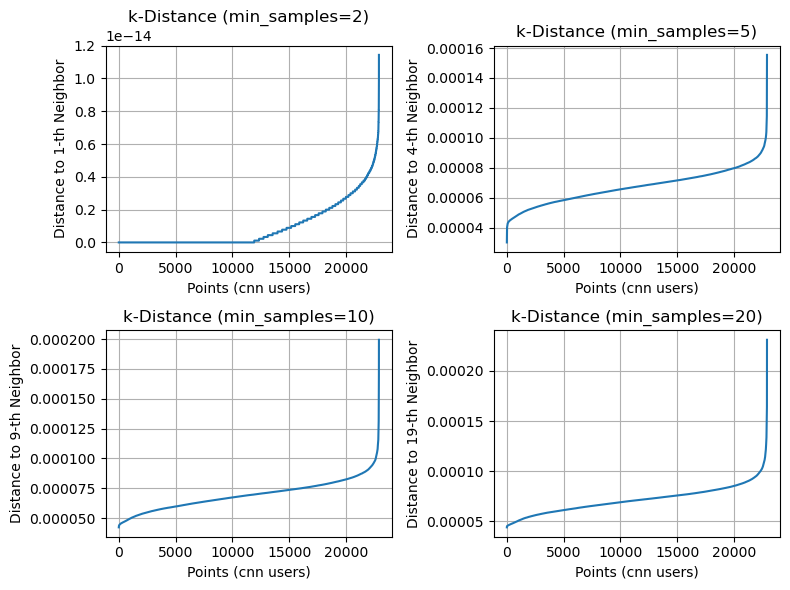

In [109]:
#plot k-distance graph with different candidates min_samples values

candidate_min_samples = [2, 5, 10, 20]

#for key in distance_matrices.keys():
key= 'cnn'

#create subplots
fig, ax = plt.subplots( 2, 2, figsize=(8, 6))
# Flatten axes for easier iteration
ax = ax.flatten()

for i, min_sample in enumerate(candidate_min_samples):
# Find the k-nearest neighbors (k = min_samples - 1)
    k = min_sample - 1
    neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
    neighbors.fit(distance_matrices[key])

    # Compute the distances to the k-th nearest neighbor for each user
    distances, indices = neighbors.kneighbors(distance_matrices[key])

    # Sort distances and plot
    sorted_distances = np.sort(distances[:, -1])
    ax[i].plot(sorted_distances)
    ax[i].set_title(f"k-Distance (min_samples={min_sample})")
    ax[i].set_xlabel(f"Points ({key} users)")
    ax[i].set_ylabel(f"Distance to {k}-th Neighbor")
    ax[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


##### Test DBSCAN clustering with relevant eps/min_samples combinations

First, we try bubbling the FOX users with several eps/min_samples combinations until we obtain a satisfactory result, i.e having some bubbles and not tooo many outliers.

In [110]:
eps_values = [0.6, 0.8, 0.9]
min_samples_values = [4, 5, 10, 50, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        # Count clusters and outliers
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_clusters} clusters, {n_outliers} outliers")

eps=0.600000, min_samples=4: 0 clusters, 17372 outliers
eps=0.600000, min_samples=5: 0 clusters, 17372 outliers
eps=0.600000, min_samples=10: 0 clusters, 17372 outliers
eps=0.600000, min_samples=50: 0 clusters, 17372 outliers
eps=0.600000, min_samples=100: 0 clusters, 17372 outliers
eps=0.800000, min_samples=4: 8 clusters, 17014 outliers
eps=0.800000, min_samples=5: 5 clusters, 17031 outliers
eps=0.800000, min_samples=10: 3 clusters, 17056 outliers
eps=0.800000, min_samples=50: 2 clusters, 17180 outliers
eps=0.800000, min_samples=100: 0 clusters, 17372 outliers
eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
eps=0.900000, min_samples=5: 6 clusters, 11868 outliers
eps=0.900000, min_samples=10: 3 clusters, 11989 outliers
eps=0.900000, min_samples=50: 1 clusters, 12555 outliers
eps=0.900000, min_samples=100: 1 clusters, 12863 outliers


We can see that min_sample = 50 and 100 give very few bubbles, indicating that the minimum size is too high. We thus continue our tests with 4, 5 and 10, while zooming in eps_values between 0.85 and 0.95.

In [111]:
eps_values = [0.85, 0.88, 0.89, 0.91, 0.93, 0.95]
min_samples_values = [4, 5, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        # Count clusters and outliers
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_clusters} clusters, {n_outliers} outliers")

eps=0.850000, min_samples=4: 15 clusters, 15963 outliers
eps=0.850000, min_samples=5: 11 clusters, 15985 outliers
eps=0.850000, min_samples=10: 4 clusters, 16109 outliers
eps=0.880000, min_samples=4: 12 clusters, 14200 outliers
eps=0.880000, min_samples=5: 7 clusters, 14240 outliers
eps=0.880000, min_samples=10: 3 clusters, 14356 outliers
eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
eps=0.890000, min_samples=5: 6 clusters, 13174 outliers
eps=0.890000, min_samples=10: 3 clusters, 13310 outliers
eps=0.910000, min_samples=4: 3 clusters, 10239 outliers
eps=0.910000, min_samples=5: 2 clusters, 10274 outliers
eps=0.910000, min_samples=10: 2 clusters, 10390 outliers
eps=0.930000, min_samples=4: 4 clusters, 6149 outliers
eps=0.930000, min_samples=5: 2 clusters, 6177 outliers
eps=0.930000, min_samples=10: 1 clusters, 6288 outliers
eps=0.950000, min_samples=4: 1 clusters, 2012 outliers
eps=0.950000, min_samples=5: 1 clusters, 2024 outliers
eps=0.950000, min_samples=10: 1 clusters, 205

Interesting parameter combinations for FOX:

    eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
    eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
    eps=0.910000, min_samples=4: 3 clusters, 10239 outliers

Parameters chosen for all clusters: 

    eps = 0.9 
    min_samples = 8 (4 was too low for the other clusters)    

In [27]:
opt_eps = 0.9
opt_min_samples = 8

#initialize dict to store labels from dbscan
labels_dict = {}

#iterate on the 5 clusters
for key in distance_matrices.keys():
    #print cluster name (channel)
    #print(key)

    #define clustring model
    model = DBSCAN(eps=opt_eps, min_samples=8, metric='precomputed')

    #1D array containing the bubble to which each user belongs, in the same order of the users of sparse matrix
    labels = model.fit_predict(distance_matrices[key])  
    #print('Total number of users:', len(labels))
    
    #add labels to dict
    labels_dict[key] = labels                                 

    # Count clusters and outliers
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)

    #print(f"eps={opt_eps:.6f}, min_samples={opt_min_samples}: {n_clusters} bubbles, {n_outliers} outliers")

In [113]:
#count users in each bubble
from collections import Counter

#iterate on clusters (channel)
for key in labels_dict.keys():
    cluster_counts = Counter(labels_dict[key])

    # Print the number of users in each cluster
    print("Number of users in each bubble,", key, ":")
    for cluster, count in cluster_counts.items():
        if cluster == -1:
            print(f"Outliers: {count} users")
        else:
            print(f"Cluster {cluster}: {count} users")

Number of users in each bubble, cnn :
Outliers: 14326 users
Cluster 0: 8518 users
Cluster 2: 16 users
Cluster 1: 9 users
Cluster 4: 8 users
Cluster 5: 10 users
Cluster 3: 8 users
Number of users in each bubble, abc :
Outliers: 25983 users
Cluster 0: 7238 users
Cluster 8: 16 users
Cluster 20: 6 users
Cluster 7: 9 users
Cluster 13: 9 users
Cluster 2: 36 users
Cluster 12: 26 users
Cluster 16: 6 users
Cluster 14: 5 users
Cluster 1: 15 users
Cluster 11: 8 users
Cluster 9: 5 users
Cluster 6: 10 users
Cluster 3: 13 users
Cluster 19: 18 users
Cluster 21: 6 users
Cluster 4: 7 users
Cluster 22: 7 users
Cluster 10: 18 users
Cluster 5: 6 users
Cluster 23: 10 users
Cluster 18: 9 users
Cluster 15: 11 users
Cluster 17: 7 users
Cluster 24: 5 users
Cluster 25: 10 users
Number of users in each bubble, bbc :
Outliers: 7988 users
Cluster 0: 2254 users
Cluster 12: 19 users
Cluster 1: 59 users
Cluster 19: 9 users
Cluster 3: 8 users
Cluster 5: 9 users
Cluster 4: 8 users
Cluster 2: 8 users
Cluster 14: 4 users

#### Trying different visualization methods on FOX (PCA, t-SNE, and Networkx)

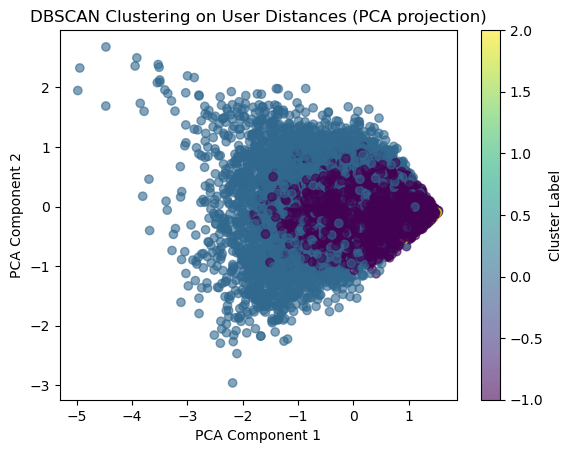

In [114]:
#visualize bubbles using PCA

from sklearn.decomposition import PCA

# Get the distance matrix for a given subset (e.g., for key = 'subset_1')
distance_matrix = distance_matrices['fox']

# Apply PCA to reduce to 2D (or 3D if you prefer)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(distance_matrix)

# Plotting the 2D representation
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_dict['fox'], cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering on User Distances (PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

python(1018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


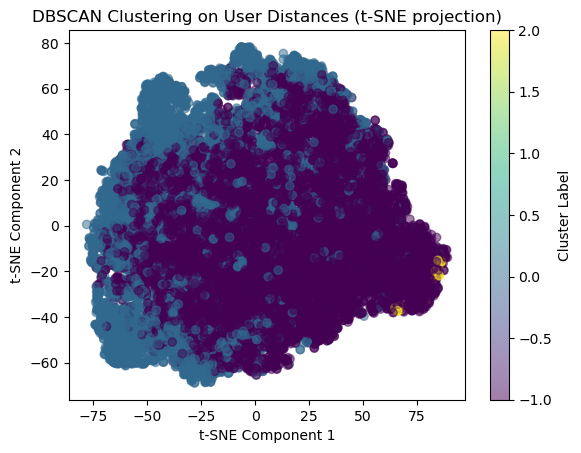

In [115]:
from sklearn.manifold import TSNE

distance_matrix = distance_matrices['fox']

# Apply t-SNE to the distance matrix (you can also use PCA first if needed)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(distance_matrix)

# Plotting the 2D t-SNE result
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels_dict['fox'], cmap='viridis', alpha = 0.5)
plt.title('DBSCAN Clustering on User Distances (t-SNE projection)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

##### Generate sparse matrices for each bubble (or read from files)

I know this is probably not the best way to generate multiple paths, I will find something cleaner next week !!!!

In [15]:
# filenames where we want to save the video-author matrices of the bubbles

#store paths in dict for easier itration
bubbles_paths = { 'cnn' : [dataset_root_path + "../generated_data/video_author_matrix_cnn_b0.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_cnn_b1.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_cnn_b2.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_cnn_b3.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_cnn_b4.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_cnn_b5.npz"],
                'abc' : [dataset_root_path + "../generated_data/video_author_matrix_abc_b0.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b1.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b2.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b3.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b4.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b5.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b6.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b7.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b8.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b9.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b10.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b11.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b12.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b13.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b14.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b15.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b16.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b17.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b18.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b19.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b20.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b21.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b22.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b23.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b24.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_abc_b25.npz"], 
                'bbc' : [dataset_root_path + "../generated_data/video_author_matrix_bbc_b0.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b1.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b2.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b3.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b4.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b5.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b6.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b7.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b8.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b9.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b10.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b11.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b12.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b13.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b14.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b15.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b16.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b17.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b18.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_bbc_b19.npz"],
                'aje' : [dataset_root_path + "../generated_data/video_author_matrix_aje_b0.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b1.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b2.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b3.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b4.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b5.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b6.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b7.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b8.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b9.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b10.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b11.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_aje_b12.npz"],
                'fox' : [dataset_root_path + "../generated_data/video_author_matrix_fox_b0.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_fox_b1.npz",
                          dataset_root_path + "../generated_data/video_author_matrix_fox_b2.npz"]}

In [28]:
bubbles_video_author_matrices = {}


#iterate on clusters 
for key in labels_dict.keys():
        print(key)
                
        #get id of bubbles in the cluster
        bubbles_id = np.unique(labels_dict[key])
        bubbles_id = bubbles_id[bubbles_id != -1]  # Exclude -1 for outliers

        matrices = []

        #iterate on bubbles of the cluster
        for id in bubbles_id:
                # if the file exists, load it in the dict
                if os.path.isfile(bubbles_paths[key][id]):
                        #load and add matrix to list
                        matrices.append(scipy.sparse.load_npz(bubbles_paths[key][id]))
                        print(f"Loaded data from file")
                
                # if not, generate it
                else:
                        #get users of the bubble
                        users = np.where(labels_dict[key] == id)[0]
                        
                        #slice users from the sparse matrix of the cluster
                        matrix = video_author_matrices[key][:, users]

                        #add matrix to list
                        matrices.append(matrix)
                        
                        #save matrix in
                        scipy.sparse.save_npz(bubbles_paths[key][id], matrix)

                        print(f"Saved file {bubbles_paths[key][id]}")

                        print(f"Bubble {id}: {matrix.shape} (videos x users)")

        #add list of matrices to dict 
        bubbles_video_author_matrices[key] = matrices

cnn
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
abc
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
bbc
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from fil

## Perform pairwise overlap on the bubbles defined by DBSCAN (Manon)

- Use sparse matrices containing commenting information of the users for bubble computed by Mila. The sparse matrix has columns = users and rows = videos; if a user has commented on a video, the stored value is True. 

    The matrices are stored in a dict as follows :
        
        bubbles_video_author_matrices = {'cnn': [matrix_bubble_0, matrix_bubble_1, matrix_bubble_2, matrix_bubble_3, matrix_bubble_4, matrix_bubble_5, ...]
                                        ' abc' : [...]
                                        ' bbc' : [...]
                                        ' aje' : [...]
                                        ' fox' : [...] }
    
    Thus, if you want to access the matrices of all the bubbles within 'cnn' , you can do :   
    
        bubbles_video_author_matrices['cnn']

    If you want to acces one specific matrix (e.g. bubble 0 of cluster 'cnn') :

        bubbles_video_author_matrices['cnn'][0]

- perform pairwise overlaps (same bubble, or different bubbles) using Horti/Andreas code

#### Computing pairwise overlap between two bubbles of the **same** channel

In [ ]:

#Computing pairwise overlap within each bubble for each channel

channel_averages= dp.average_pairwise_overlap(bubbles_video_author_matrices)


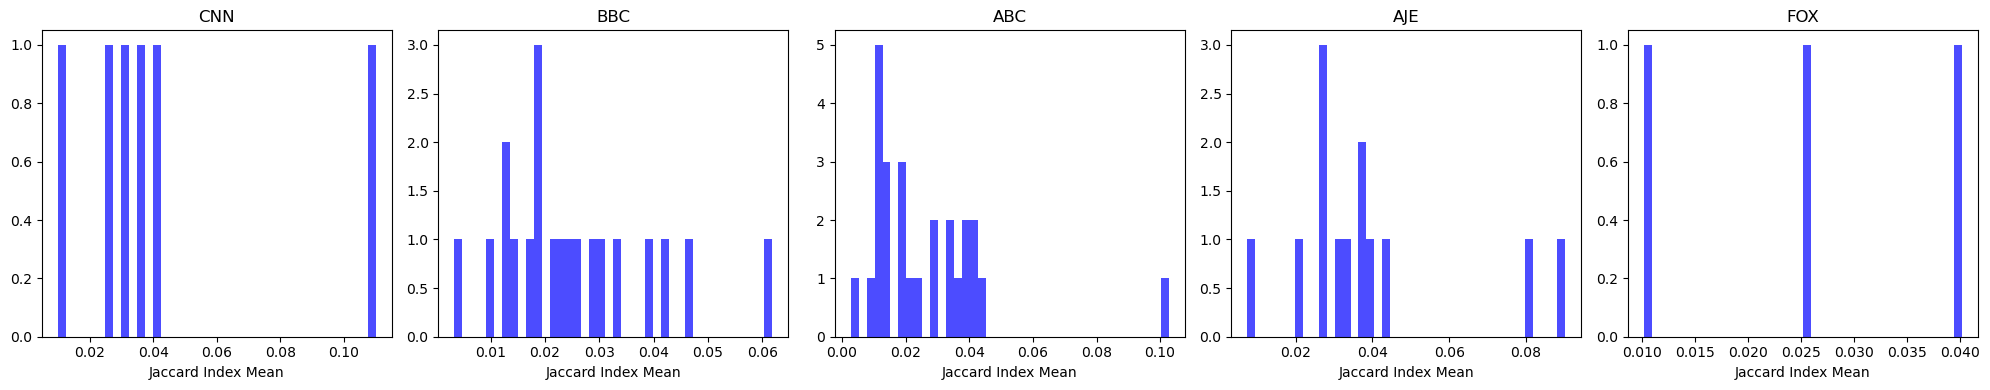

In [150]:


#mean jaccard index within bubble in a channel
data_list = [
    channel_averages['cnn'],   
    channel_averages['bbc'],   
    channel_averages['abc'],   
    channel_averages['aje'],   
    channel_averages['fox']  
]

# Titles for each subplot
titles = ["CNN", "BBC", "ABC", "AJE", "FOX"]

# Create a figure with 5 subplots in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  

#plotting the whole
for i, (data, ax) in enumerate(zip(data_list, axes)):
    ax.hist(data, bins=40, color='blue', alpha=0.7)  
    ax.set_title(titles[i])  
    ax.set_xlabel("Jaccard Index Mean")  


# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

#### Computing pairwise overlap between two bubbles of **different** channels

In [148]:
#extracting user_id for each bubble of each cluster

def extract_user_id (cluster, channel_name ):
    channel_bubbles_user_id = {}
    
    num_bubbles = len(set(labels_dict[channel_name]))  # Number of unique bubbles for this channel
    
    for i in range(num_bubbles-1):
        # Extract user IDs corresponding to the current bubble
        user_ids = list(cluster.author.iloc[(labels_dict[channel_name] == i).nonzero()])
        channel_bubbles_user_id[i] = user_ids
    
    return channel_bubbles_user_id





In [ ]:

def compute_pairwise_overlap(cluster, channel_name, labels_dict, bubbles_video_author_matrices):
    # Extract user id for each bubble
    channel_bubbles_user_id = extract_user_id(cluster, channel_name)
    
    # Initialize list to store the pairwise Jaccard means
    average_mean_jaccard_between = []
    
    # Number of bubbles for the current channel
    num_bubbles = len(channel_bubbles_user_id)
    
    # Compute pairwise overlap
    for i in range(num_bubbles):
        for j in range(i + 1, num_bubbles):  # Avoid double counting by starting j from i+1
            # Compute the Jaccard similarity between bubble i and bubble j
            average = dp.get_jacc_mean_between_two_clusters(
                bubbles_video_author_matrices[channel_name][i],
                bubbles_video_author_matrices[channel_name][j],
                pd.Series(channel_bubbles_user_id[i]),
                pd.Series(channel_bubbles_user_id[j])
            )
            average_mean_jaccard_between.append(average)
    
    return average_mean_jaccard_between


average_mean_jaccard_cnn_between = compute_pairwise_overlap(cluster_cnn, 'cnn', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_abc_between = compute_pairwise_overlap(cluster_abc, 'abc', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_bbc_between = compute_pairwise_overlap(cluster_bbc, 'bbc', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_aje_between = compute_pairwise_overlap(cluster_aje, 'aje', labels_dict, bubbles_video_author_matrices)
average_mean_jaccard_fox_between = compute_pairwise_overlap(cluster_fox, 'fox', labels_dict, bubbles_video_author_matrices)

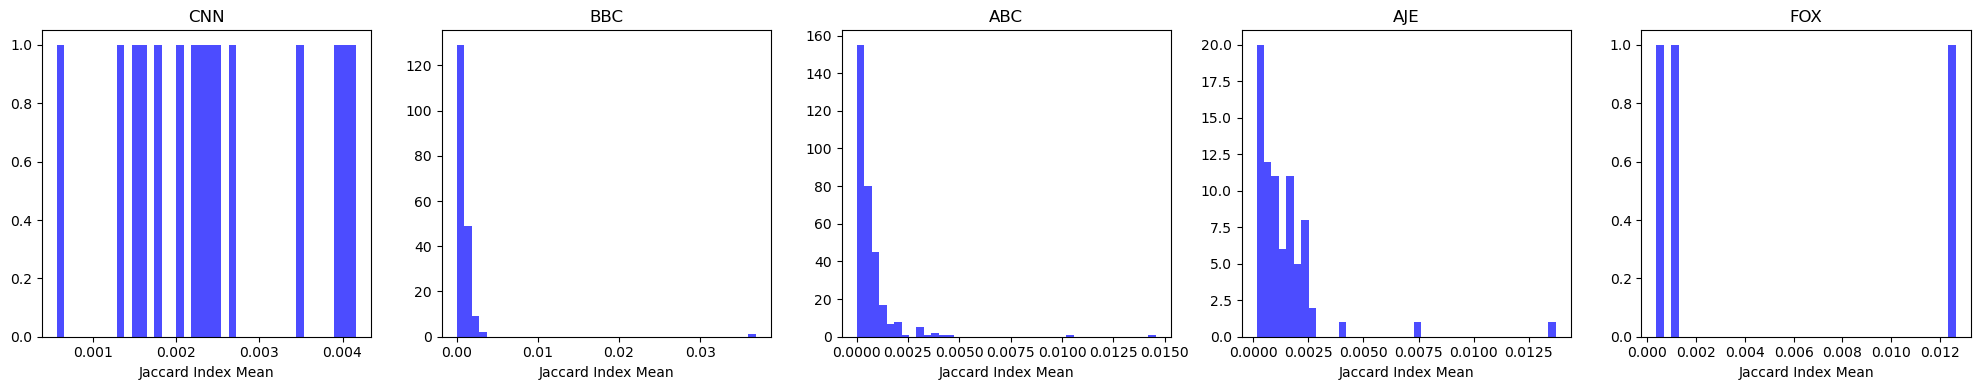

In [149]:
#mean jaccard index within bubble in a channel
data_list = [
    average_mean_jaccard_cnn_between,   
    average_mean_jaccard_bbc_between,   
    average_mean_jaccard_abc_between,   
    average_mean_jaccard_aje_between,   
    average_mean_jaccard_fox_between  
]

# Titles for each subplot
titles = ["CNN", "BBC", "ABC", "AJE", "FOX"]

# Create a figure with 5 subplots in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  

#plotting the whole
for i, (data, ax) in enumerate(zip(data_list, axes)):
    ax.hist(data, bins=40, color='blue', alpha=0.7)  
    ax.set_title(titles[i])  
    ax.set_xlabel("Jaccard Index Mean")  


# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()


Comparing the average jaccard index , which is indicative of the pairwise overlapping, between the bubbles and the one within the bubbles for each channels, we  see that for each the overlap is quite low as expected. Furthermore as expected the users overlap between the bubbles in a channel is much lower (factor of 10) than the overlap of users within a bubble. This shows that the bubbles are correctly clustered and doesnt overlap each other in a channel. Users interested by similar videos dont really mix with users in other clusters having other interests. 

# Part 4: Word of interest

## Looking at cluster bubbles : cnn, abc, bbc, aje, fox


In [4]:
#loading videos_new_pol
video_filepath = dataset_root_path + "../generated_data/videos_in_news_pol.csv"
videos_new_pol = pd.read_csv(video_filepath)

In [11]:
# Clusters 
clusters = {
    'CNN': video_author_matrix_cnn_cluster,
    'BBC': video_author_matrix_bbc_cluster,
    'ABC': video_author_matrix_abc_cluster,
    'AJE': video_author_matrix_aje_cluster,
    'FOX': video_author_matrix_fox_cluster
}


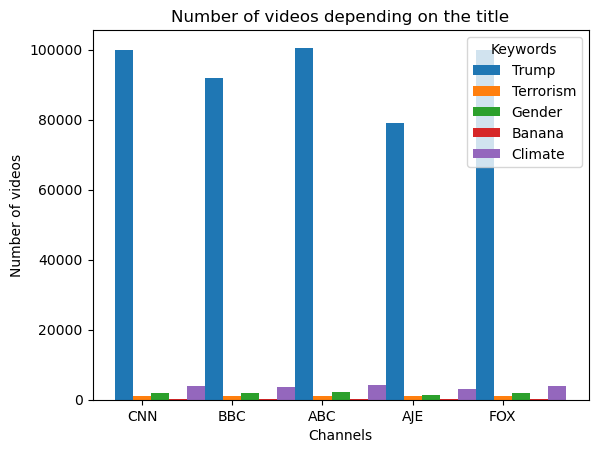

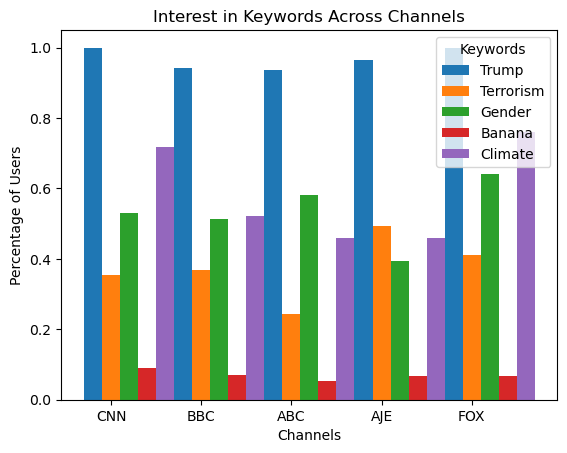

In [36]:
keywords = ['Trump', 'Terrorism', 'Gender', 'Banana', 'Climate']
dp.process_and_plot_word_interest(clusters, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


## ANALYSIS


--> Trump has way way more videos then the rest of the chosen word, we excluded it because it's too much.
Trump seems to be a main topic between all clusters.
Also, almost all users has commented under at least one video who title has Trump in its title __> shows the great interest of internaut for the man. Compared to it, more general topics as terrorism or climate is less seen, but still research.
Funny joke for banana word, and also control sample, which shows that this word is less titled, BUT still hundred of videos has this word in its title!!

# What if we took related word?

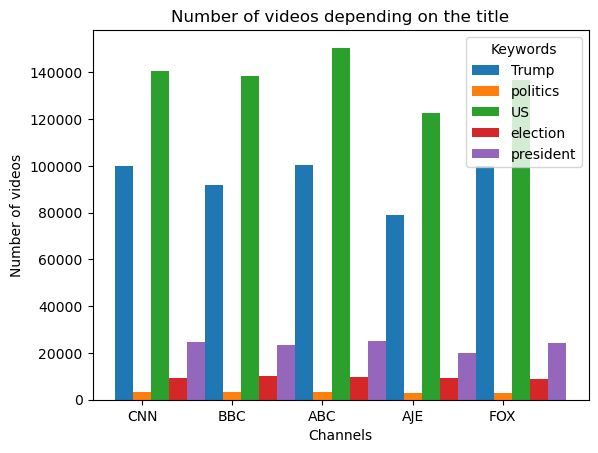

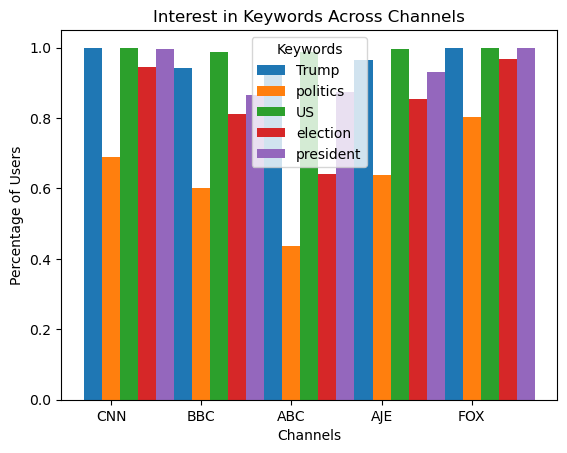

In [37]:
keywords = ['Trump', 'politics', 'US', 'election', 'president']
dp.process_and_plot_word_interest(clusters, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


## ANALYSIS

we decide to took related words in order to see how muh it is utilized by users, and no surprise, the related politics words seems to have more then half of it users that has commented under at least one of the videos that has one of the chosen word in its title. 
Have to blablabla ?

## Who is the most popular personality between the different country's leader? 

We choose 5 leaders that seem to be a problem for us, and we compare how much they appear in the title of the videos our users has commented under -> describing their popularity

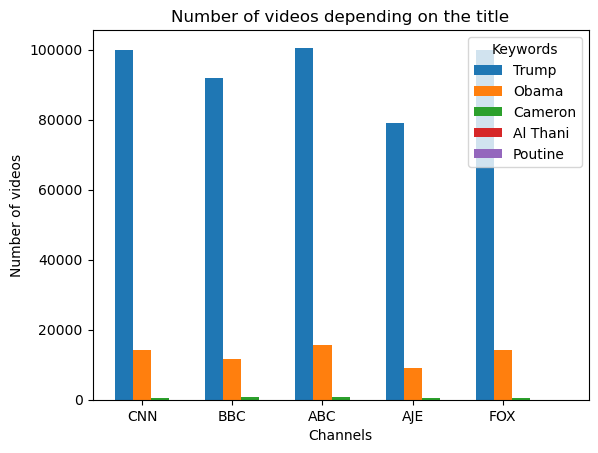

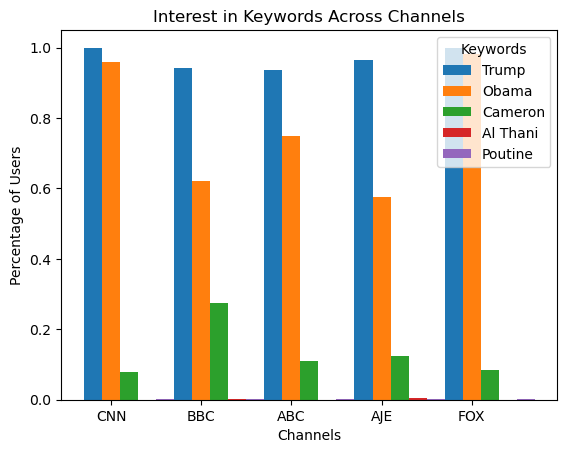

In [38]:
keywords= ['Trump','Obama','Cameron','Al Thani', 'Poutine']
dp.process_and_plot_word_interest(clusters, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


### What about between different topics ? Can we find the most popular? 

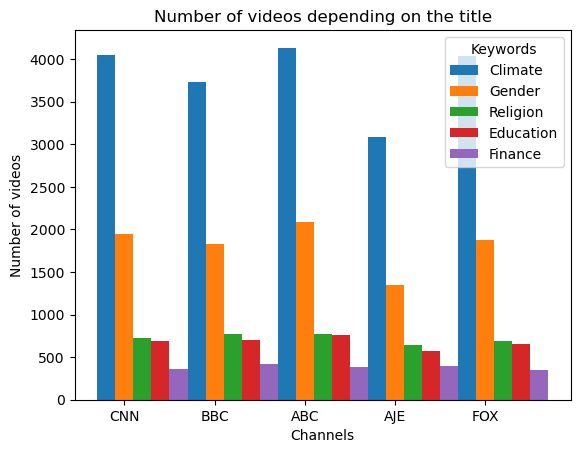

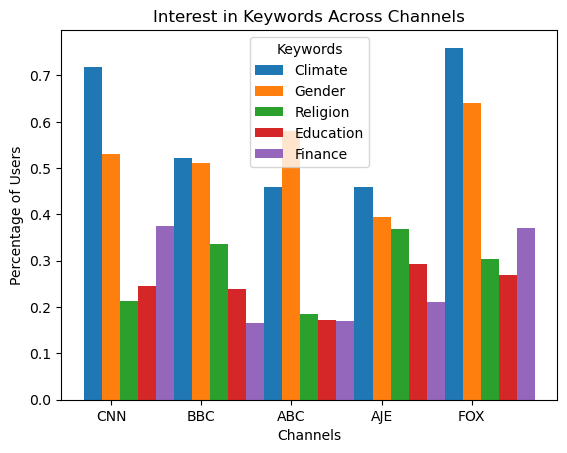

In [39]:
keywords= ['Climate','Gender','Religion','Education', 'Finance']
dp.process_and_plot_word_interest(clusters, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


## What about within the clusters? Do all users participate or only certain bubbles?
Bubbles within a cluster, 5 most relevant cluster

In [45]:
#CNN

bubbles_interest_cnn = {
    'bubble 1': bubbles_video_author_matrices['cnn'][0],
    'bubble 2': bubbles_video_author_matrices['cnn'][2],
    'bubble 3': bubbles_video_author_matrices['cnn'][5]
}

#BBC
bubbles_interest_bbc = {
    'bubble 1': bubbles_video_author_matrices['bbc'][0],
    'bubble 2': bubbles_video_author_matrices['bbc'][6],
    'bubble 3': bubbles_video_author_matrices['bbc'][8]
}

#ABC
bubbles_interest_abc = {
    'bubble 1': bubbles_video_author_matrices['abc'][0],
    'bubble 2': bubbles_video_author_matrices['abc'][3],
    'bubble 3': bubbles_video_author_matrices['abc'][6]
}

#AJE
bubbles_interest_aje = {
    'bubble 1': bubbles_video_author_matrices['aje'][0],
    'bubble 2': bubbles_video_author_matrices['aje'][2],
    'bubble 3': bubbles_video_author_matrices['aje'][3]
}

#FOX
bubbles_interest_fox = {
    'bubble 1': bubbles_video_author_matrices['fox'][0],
    'bubble 2': bubbles_video_author_matrices['fox'][1],
    'bubble 3': bubbles_video_author_matrices['fox'][2]
}

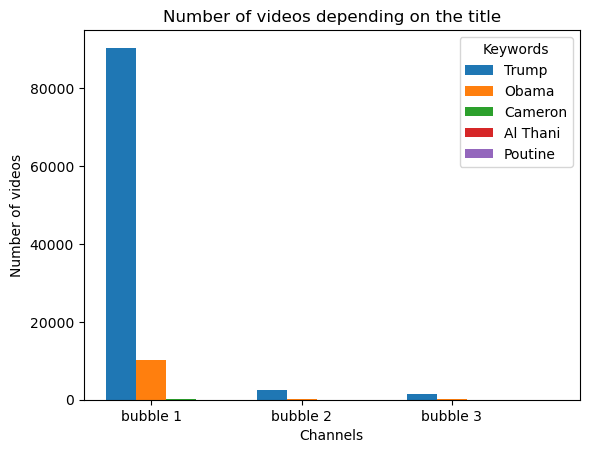

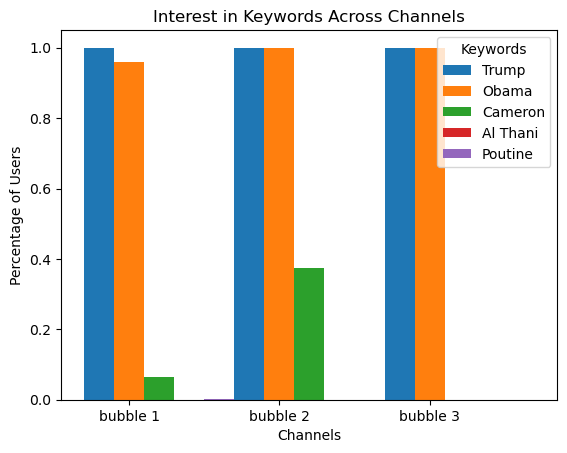

In [46]:
#Personality interest in each bubbles

#CNN
keywords= ['Trump','Obama','Cameron','Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_interest_cnn, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

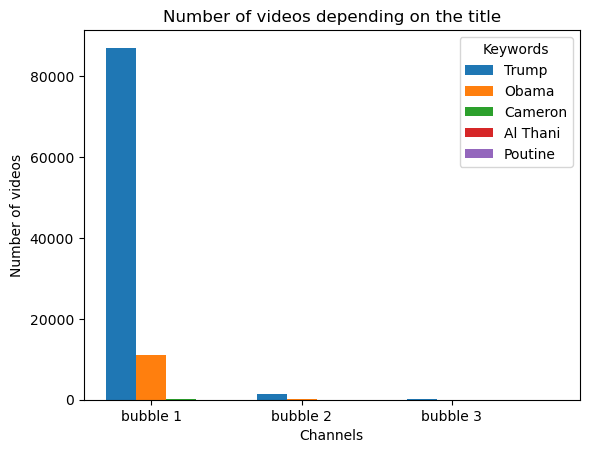

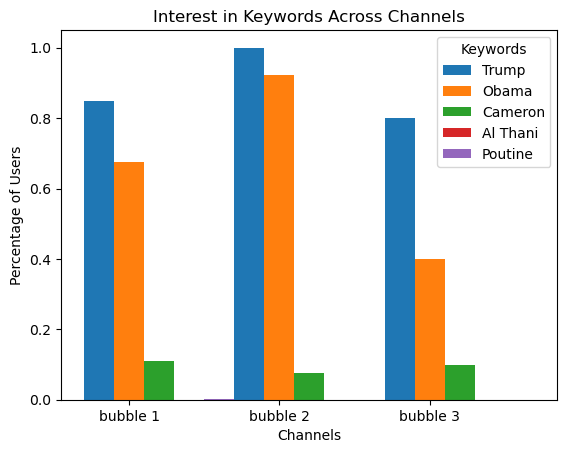

In [47]:
#BBC
keywords= ['Trump','Obama','Cameron','Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_interest_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

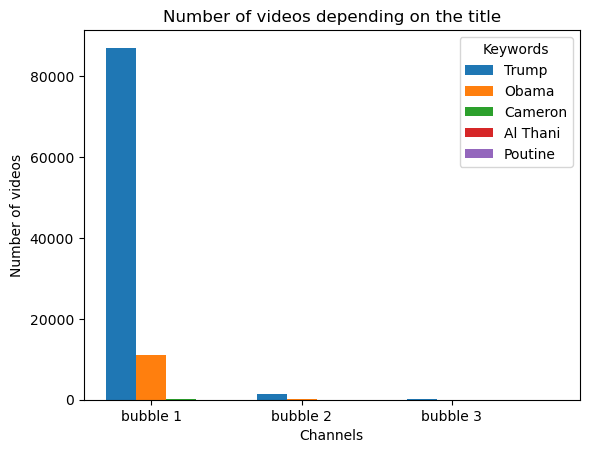

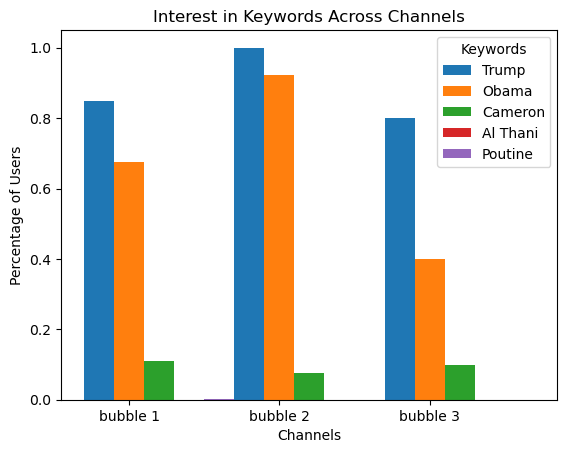

In [48]:
#ABC
keywords= ['Trump','Obama','Cameron','Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_interest_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

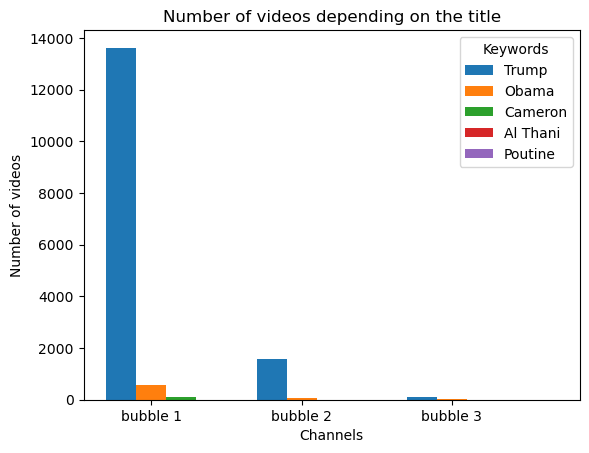

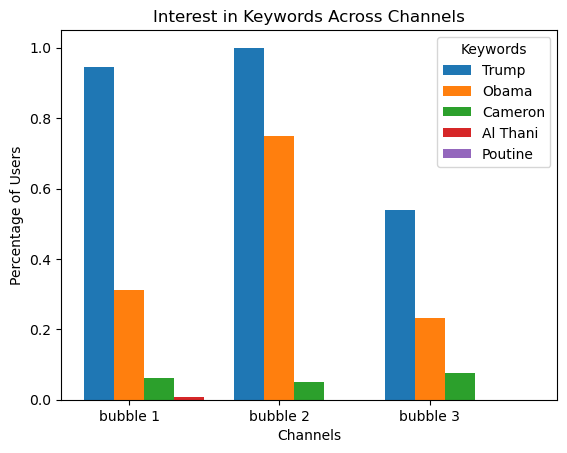

In [49]:
#AJE
keywords= ['Trump','Obama','Cameron','Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_interest_aje, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

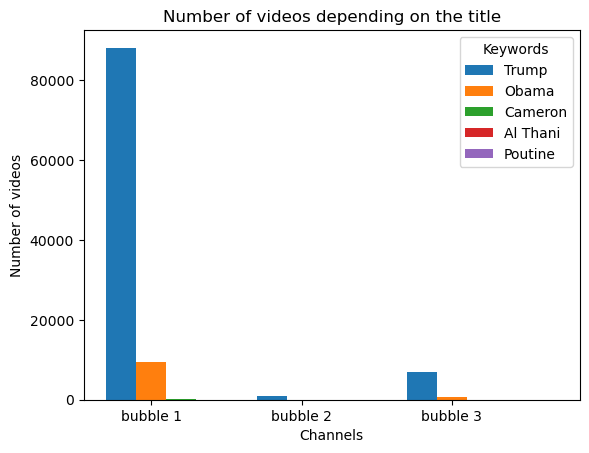

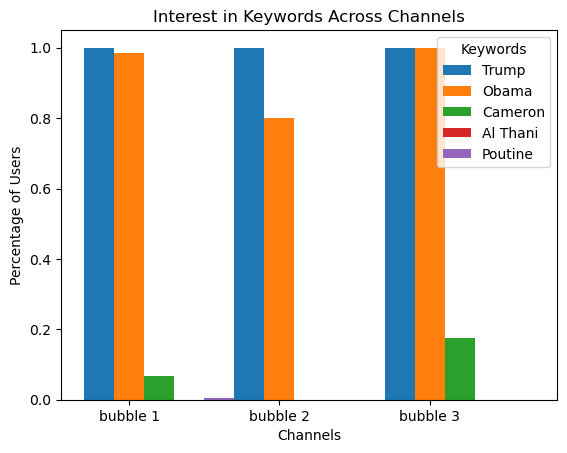

In [50]:
#Fox
keywords= ['Trump','Obama','Cameron','Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_interest_fox, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

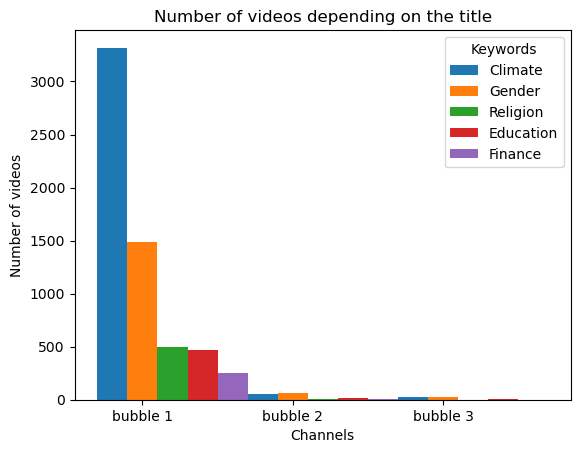

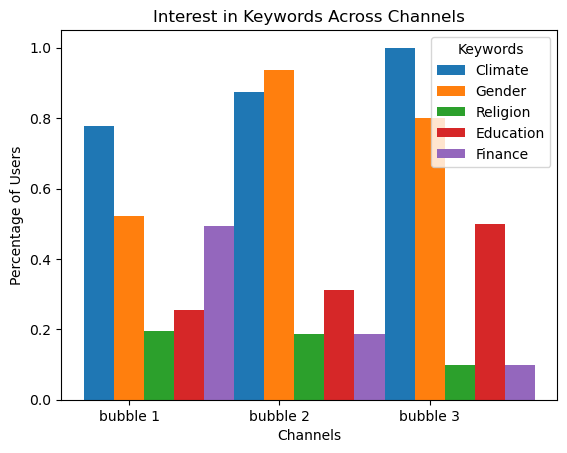

In [51]:
#Important topics

#CNN
keywords= ['Climate','Gender','Religion','Education', 'Finance']
dp.process_and_plot_word_interest(bubbles_interest_cnn, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


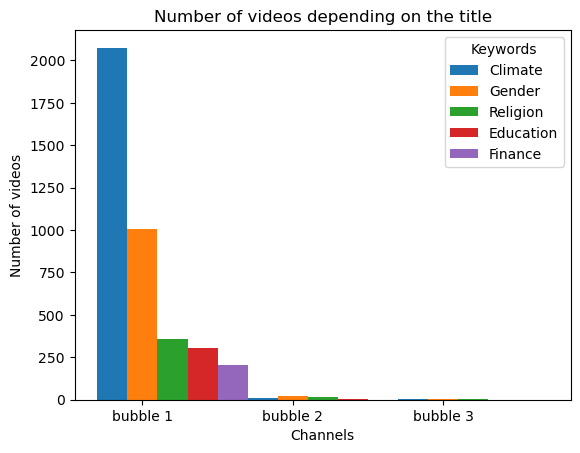

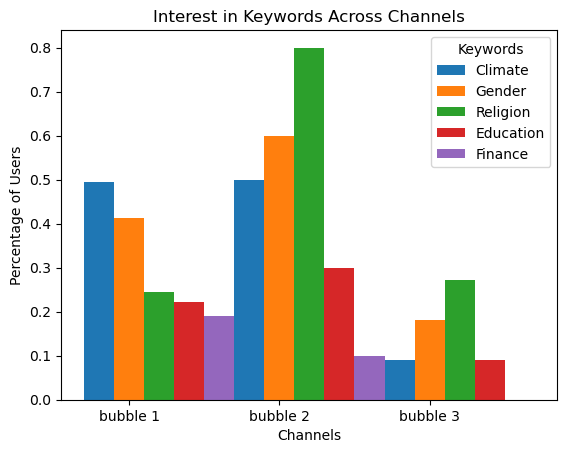

In [52]:
#BBC
keywords= ['Climate','Gender','Religion','Education', 'Finance']
dp.process_and_plot_word_interest(bubbles_interest_bbc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

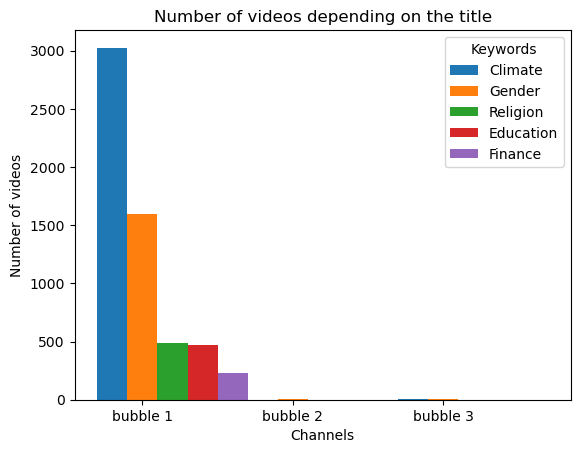

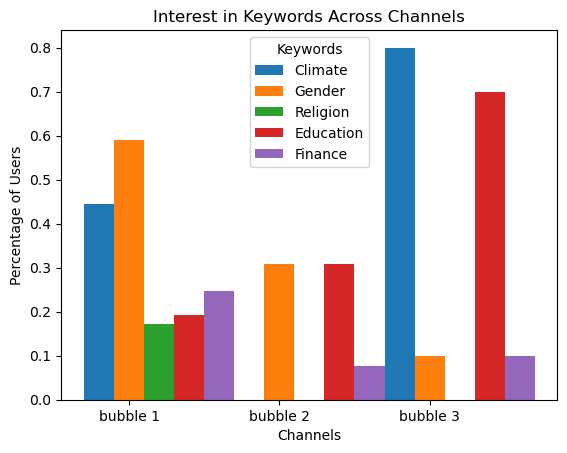

In [53]:
#ABC
keywords= ['Climate','Gender','Religion','Education', 'Finance']
dp.process_and_plot_word_interest(bubbles_interest_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

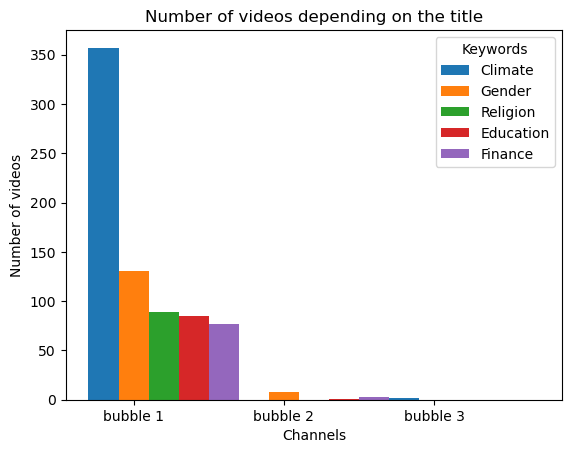

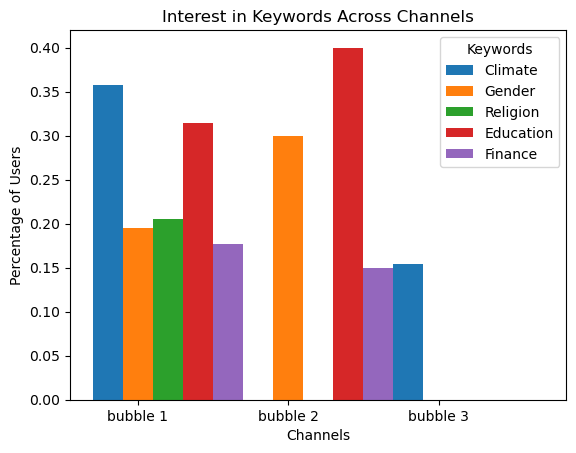

In [54]:
#AJE
keywords= ['Climate','Gender','Religion','Education', 'Finance']
dp.process_and_plot_word_interest(bubbles_interest_aje, videos_new_pol, video_ids_news_pol_int_mapping, keywords)

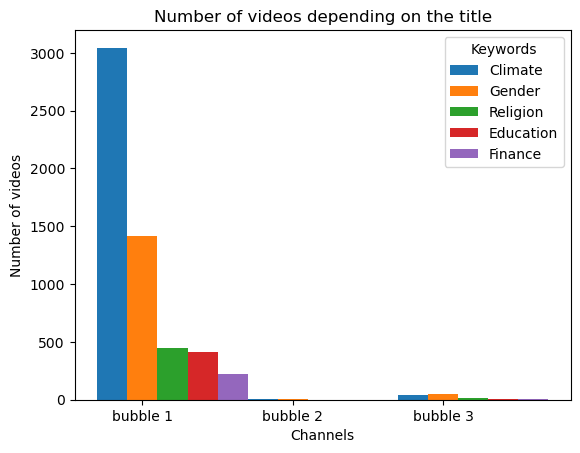

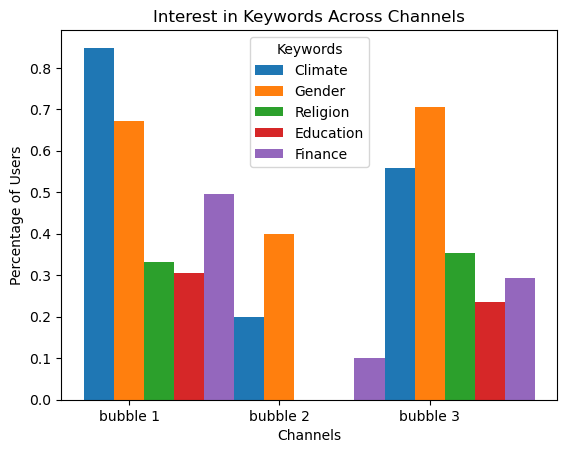

In [55]:
#Fox
keywords= ['Climate','Gender','Religion','Education', 'Finance']
dp.process_and_plot_word_interest(bubbles_interest_fox, videos_new_pol, video_ids_news_pol_int_mapping, keywords)